# CWATM: Can we recover intermediate stores from only inputs of P/T?

In [26]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path("/datadrive/data")
# run_dir = data_dir / "runs/cwatm_new_basins_0508_125737"
run_dir = Path("/datadrive/data/runs/cwatm_new_basins_CAMELSGBDataloader_1808_104714/")

out_dir = run_dir / "cell_states"

In [3]:
# GET config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

# GET preds
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

# GET trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)

100%|██████████| 864/864 [00:00<00:00, 2034.77it/s]


Using the model weights from /datadrive/data/runs/cwatm_new_basins_CAMELSGBDataloader_1808_104714/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(5, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Create the cell states

In [ ]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"
if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

Extracting cell state for basin:   0%|          | 0/864 [00:00<?, ?it/s]

Using the model weights from /datadrive/data/runs/cwatm_new_basins_CAMELSGBDataloader_1808_104714/model_epoch030.pt


Extracting cell state for basin:   5%|▍         | 39/864 [00:10<03:28,  3.96it/s]

In [27]:
cn

<xarray.Dataset>
Dimensions:     (date: 3652, dimension: 64, station_id: 864)
Coordinates:
  * date        (date) datetime64[ns] 2001-01-01 2001-01-02 ... 2010-12-31
  * station_id  (station_id) <U3 '0' '1' '10' '100' ... '96' '97' '98' '99'
  * dimension   (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
Data variables:
    c_n         (date, station_id, dimension) float32 0.01851 ... -0.03919

# Preprocess Input Data

In [ ]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# New data
station_dim = "station_id"
time_dim = "date"

# normalize ???
mean_ = cn.mean(dim=[station_dim, time_dim])
std_ = cn.std(dim=[station_dim, time_dim])
norm_cs_data = (cn - mean_) / std_
# or per station-dimension
# norm_cs_data = 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

### What do the internal states of LSTM look like?

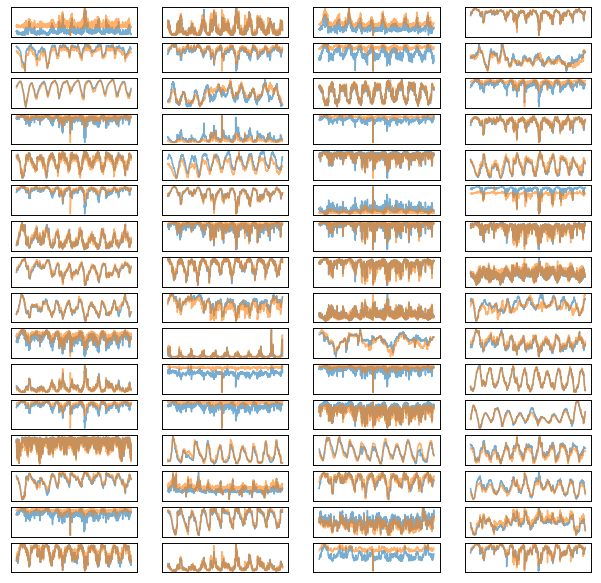

In [28]:
scale = 1.3
N_dims = 64
nrows = int(N_dims / 4)
ncols = 4
f, axs = plt.subplots(nrows, ncols, figsize=(2*scale*ncols, 0.5*scale*nrows))

pixels = np.random.choice(norm_cs_data.station_id.values, 2)

for ix in range(64):
    ax = axs[np.unravel_index(ix, (nrows, ncols))]
    for data_ix, pixel in enumerate(pixels):
        data = norm_cs_data.isel(dimension=ix). sel(station_id=pixel).to_dataframe()
        if data_ix == 1:
            ax2 = ax.twinx()
            ax2.plot(data.index, data["c_n"], alpha=0.6, color="C1")
            ax2.set_yticklabels([])
            ax2.set_yticks([])
        else:
            ax.plot(data.index, data["c_n"], alpha=0.6)
    ax.set_xticklabels([])
    ax.set_xticks([])
    
    ax.set_yticklabels([])
    ax.set_yticks([])

# Preprocess Target Data

In [65]:
cwatm = xr.open_dataset(data_dir / "cwatm_new_basins/hidden_data.nc")
cwatm = cwatm.rename({"basin": "station_id"})

dynamic =  xr.merge([cwatm, xr.open_dataset(data_dir / "cwatm_new_basins/target_data.nc").rename({"basin": "station_id"})])
dynamic.data_vars

Data variables:
    channelStorage     (station_id, time) float32 ...
    storGroundwater    (station_id, time) float32 ...
    sum_interceptStor  (station_id, time) float32 ...
    SnowCover          (station_id, time) float32 ...
    sum_w1             (station_id, time) float32 ...
    sum_w2             (station_id, time) float32 ...
    sum_w3             (station_id, time) float32 ...
    discharge          (station_id, time) float32 ...

In [130]:
from scripts.cell_state.normalize import normalize_2d_dataset

# TARGET_VARS = ["storGroundwater", "SnowCover", "sum_w1", "sum_w2", "sum_w3"]
TARGET_VARS = ["storGroundwater", "sum_w1", "sum_w2", "sum_w3"]
target_data = cwatm[TARGET_VARS].copy()

for var in target_data.data_vars:
    target_data[var] = normalize_2d_dataset(target_data[[var]], variable_str=var, per_basin=False)

In [131]:
# target_data = target_data.drop(["spatial_ref", "x", "y"])

# Create input/output data 

In [132]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [133]:
# from scripts.cell_state.timeseries_dataset import get_matching_station_ids

# get_matching_station_ids(ds1=input_data, ds2=target_data, basin_dim="station_id")

In [134]:
# all_train_test

In [149]:
target_ds = target_data.copy()
input_ds = cs

input_ds["station_id"] = input_ds["station_id"].astype(int)
target_ds["station_id"] = target_ds["station_id"].astype(int)

train_start_date: pd.Timestamp = pd.to_datetime("2001-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2010-12-31")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))

# if "all_train_test" not in globals().keys():
if True:
    all_train_test = defaultdict(dict)
    for target_var in [v for v in target_data.data_vars]:
        print(f"** STARTING {target_var} **")
        train_dataset = TimeSeriesDataset(
            input_data=input_data,
            target_data=target_data,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Train Samples",
        )
        assert train_dataset.y != {}

        train = get_time_basin_aligned_dictionary(train_dataset)

        test_dataset = TimeSeriesDataset(
            input_data=test_input_data,
            target_data=test_target_data,
            target_variable=target_var,
            input_variables=input_variables,
            seq_length=seq_length,
            basin_dim=basin_dim,
            time_dim=time_dim,
            desc="Creating Test Samples",
        )

        test = get_time_basin_aligned_dictionary(test_dataset)

        all_train_test[target_var]["train"] = train
        all_train_test[target_var]["test"] = test

** STARTING storGroundwater **


Extracting Data: 100%|██████████| 7081/7081 [00:52<00:00, 133.88it/s]


Merging and reshaping arrays


Creating Test Samples: 100%|██████████| 864/864 [00:05<00:00, 156.85it/s]
Extracting Data: 0it [00:00, ?it/s]


Merging and reshaping arrays


ValueError: need at least one array to concatenate

# Train and predictions for all models

In [ ]:
from scripts.cell_state.analysis import save_probe_components, load_probe_components

In [137]:
# initalise the model 
if "all_models_preds" not in globals().keys():
    all_models_preds = defaultdict(dict)
    target_vars = [v for v in target_data.data_vars]

    for target_var in [v for v in target_data.data_vars]:
        print(f"** {target_var} **")
        model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
        all_models_preds[target_var]["model"] = model
        all_models_preds[target_var]["preds"] = preds
        all_models_preds[target_var]["errors"] = errors

    # all_models_preds = load_probe_components(run_dir=run_dir)

In [138]:
# all_models_preds[target_var]

# Analysis

### plot timeseries

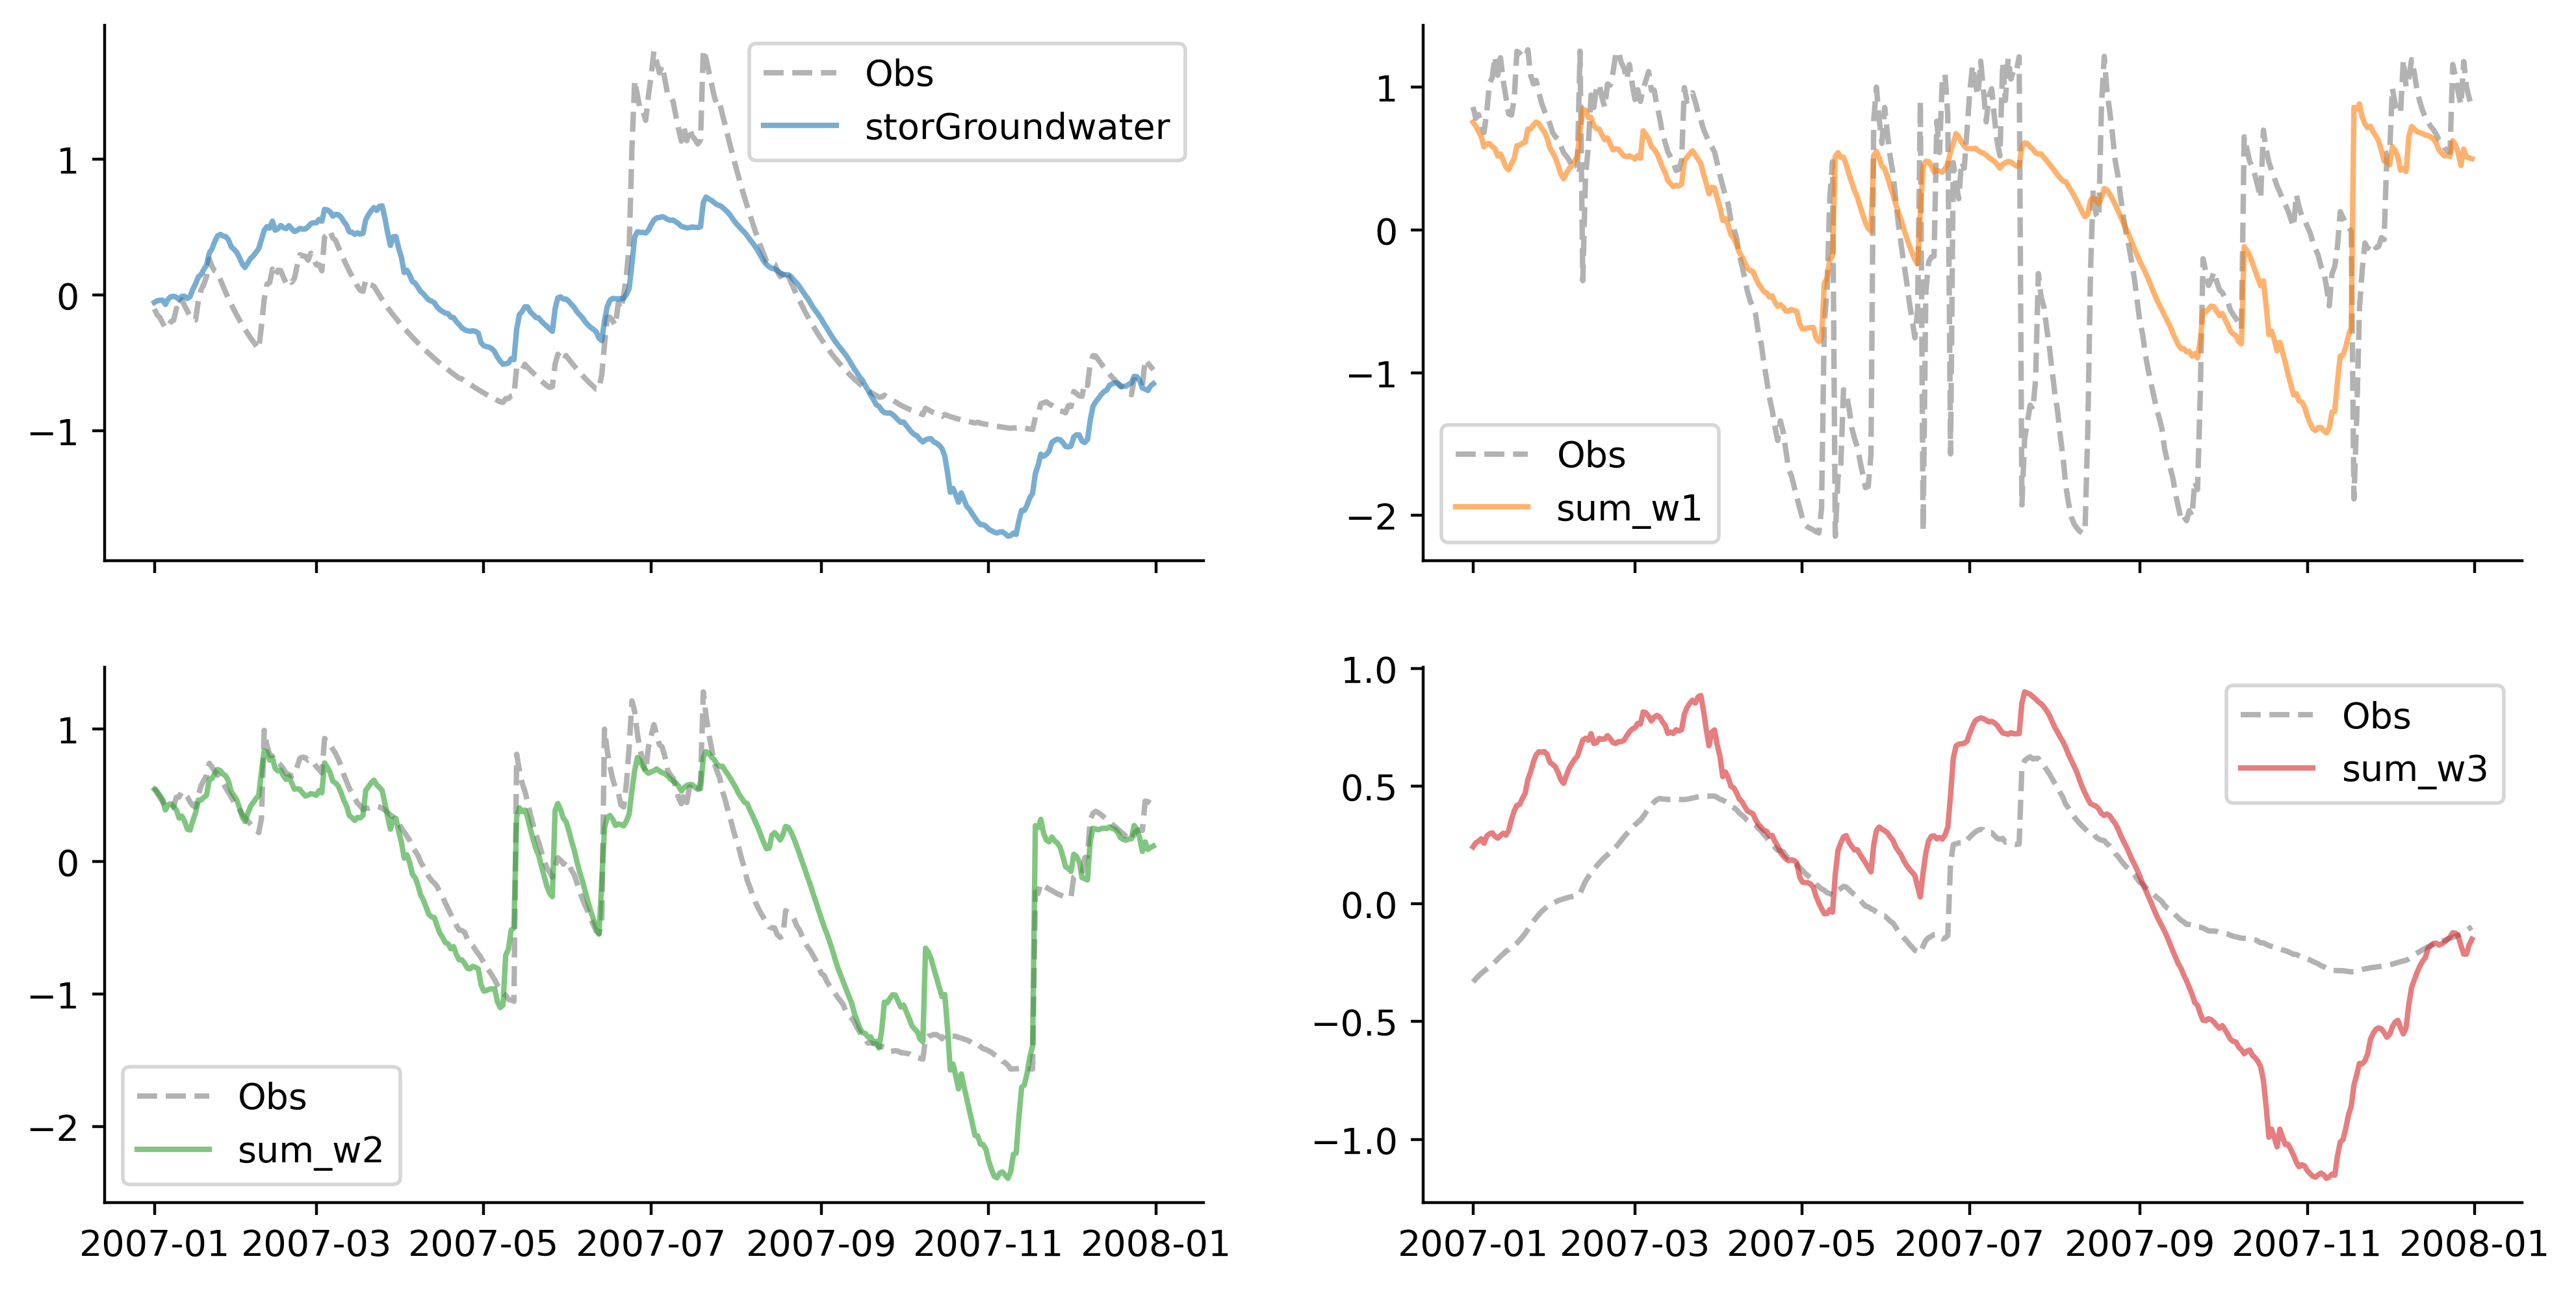

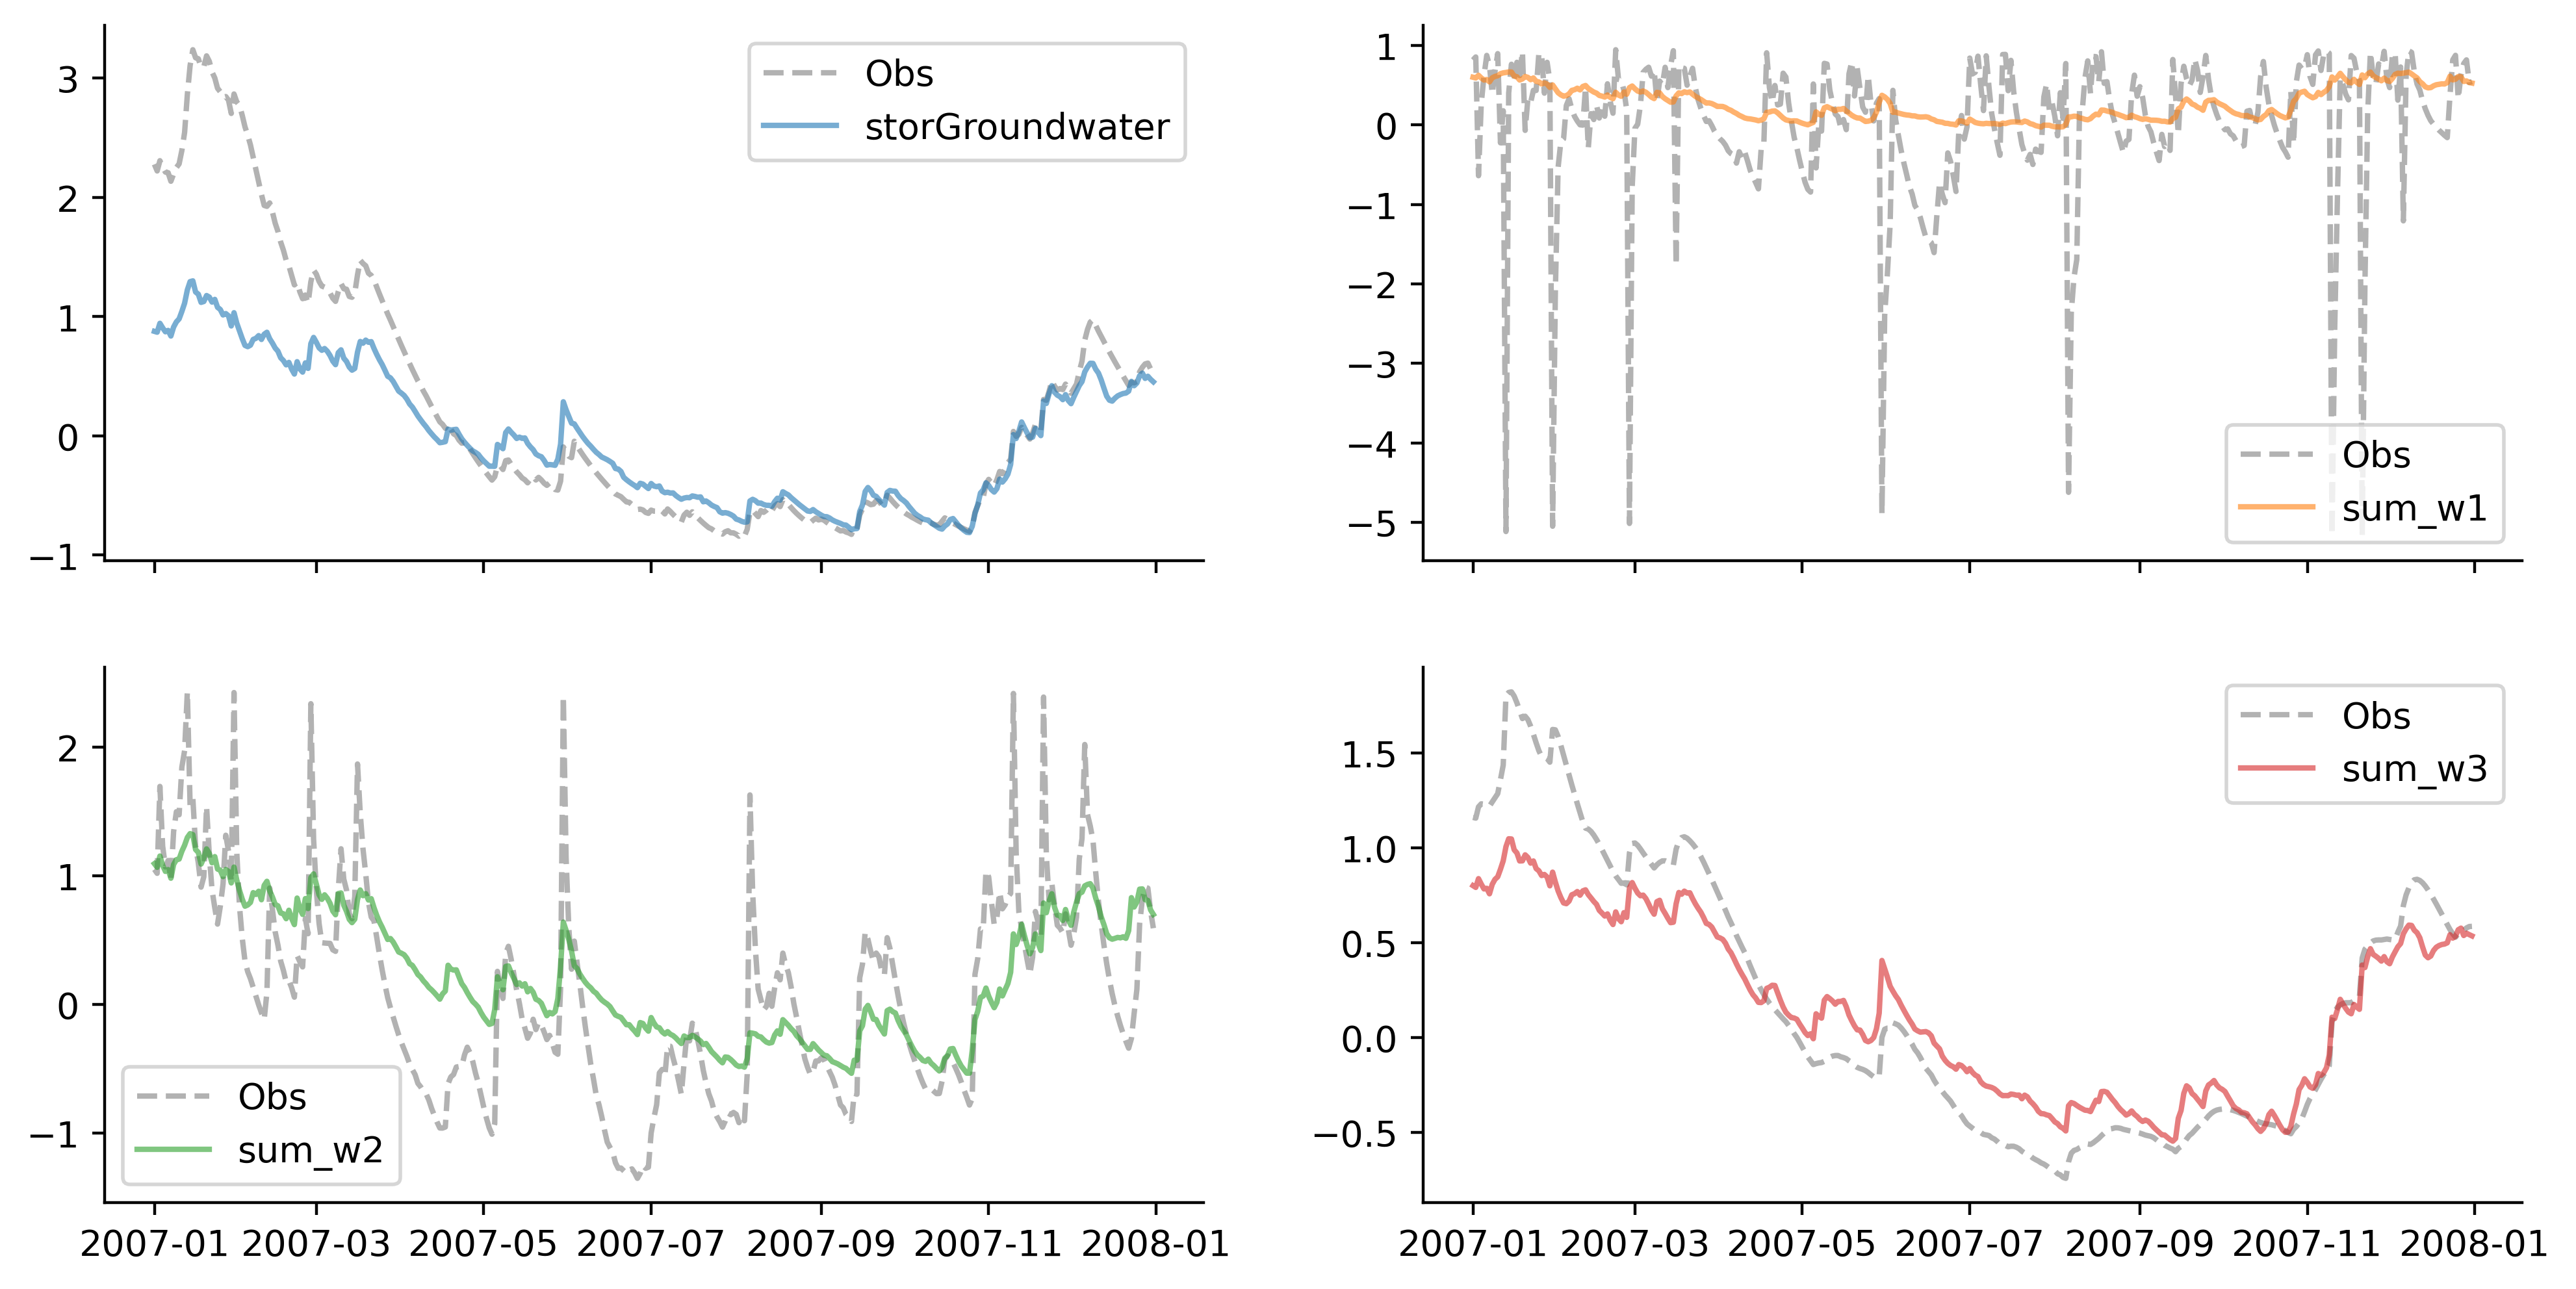

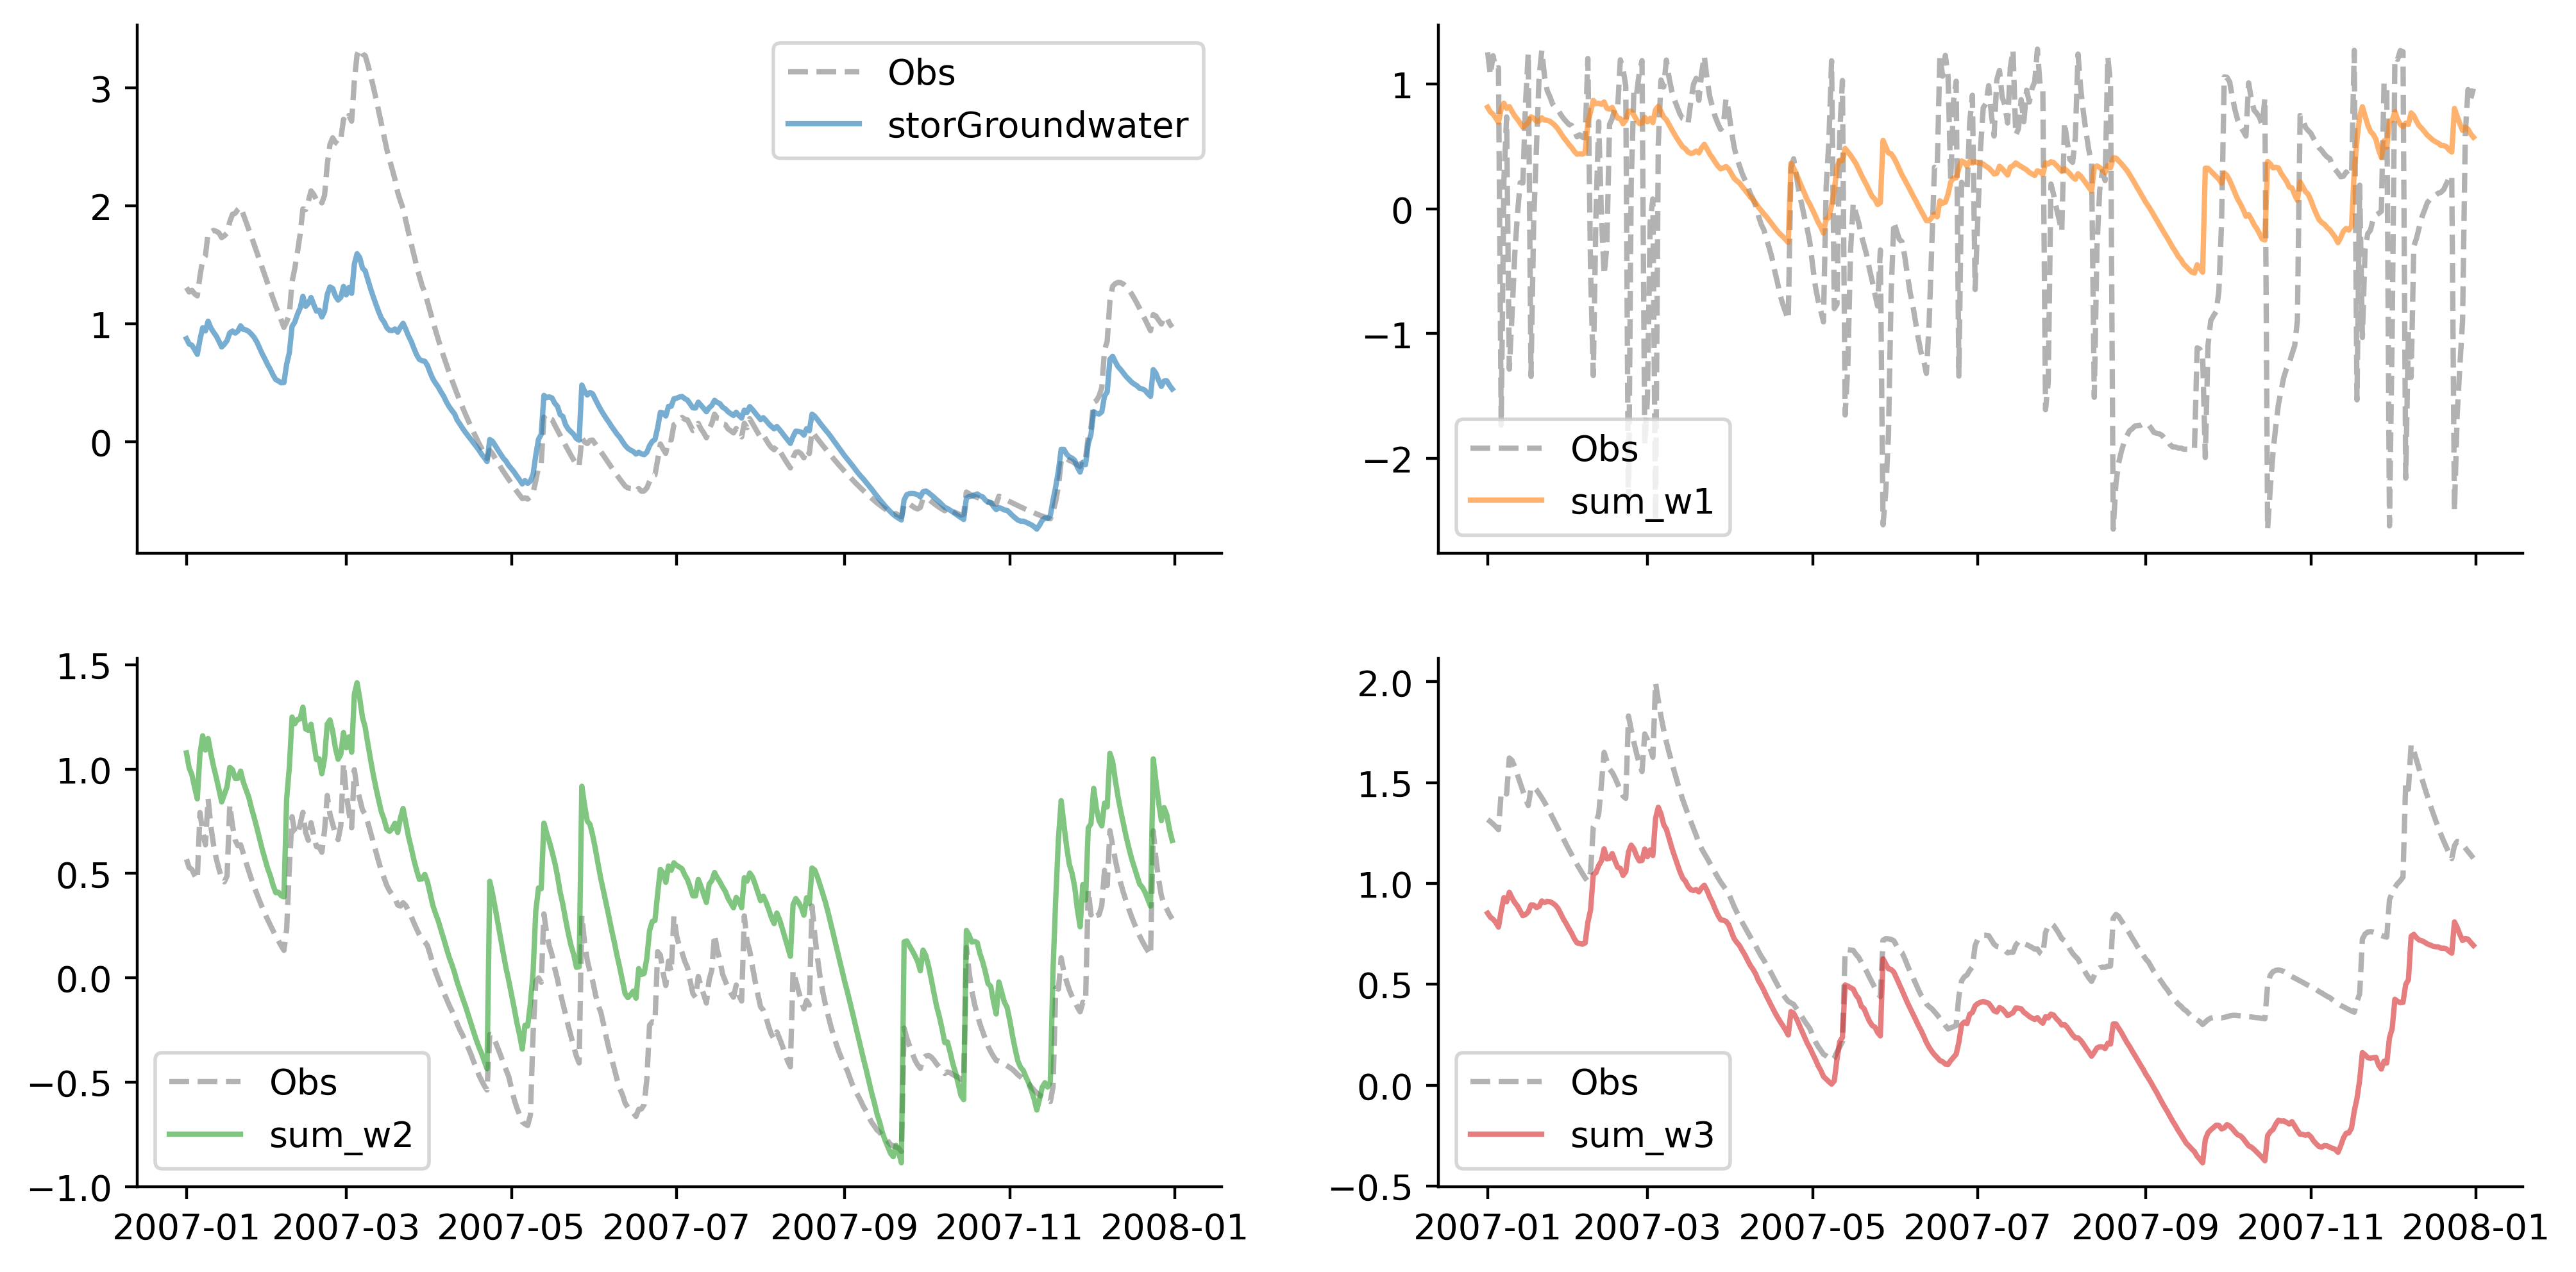

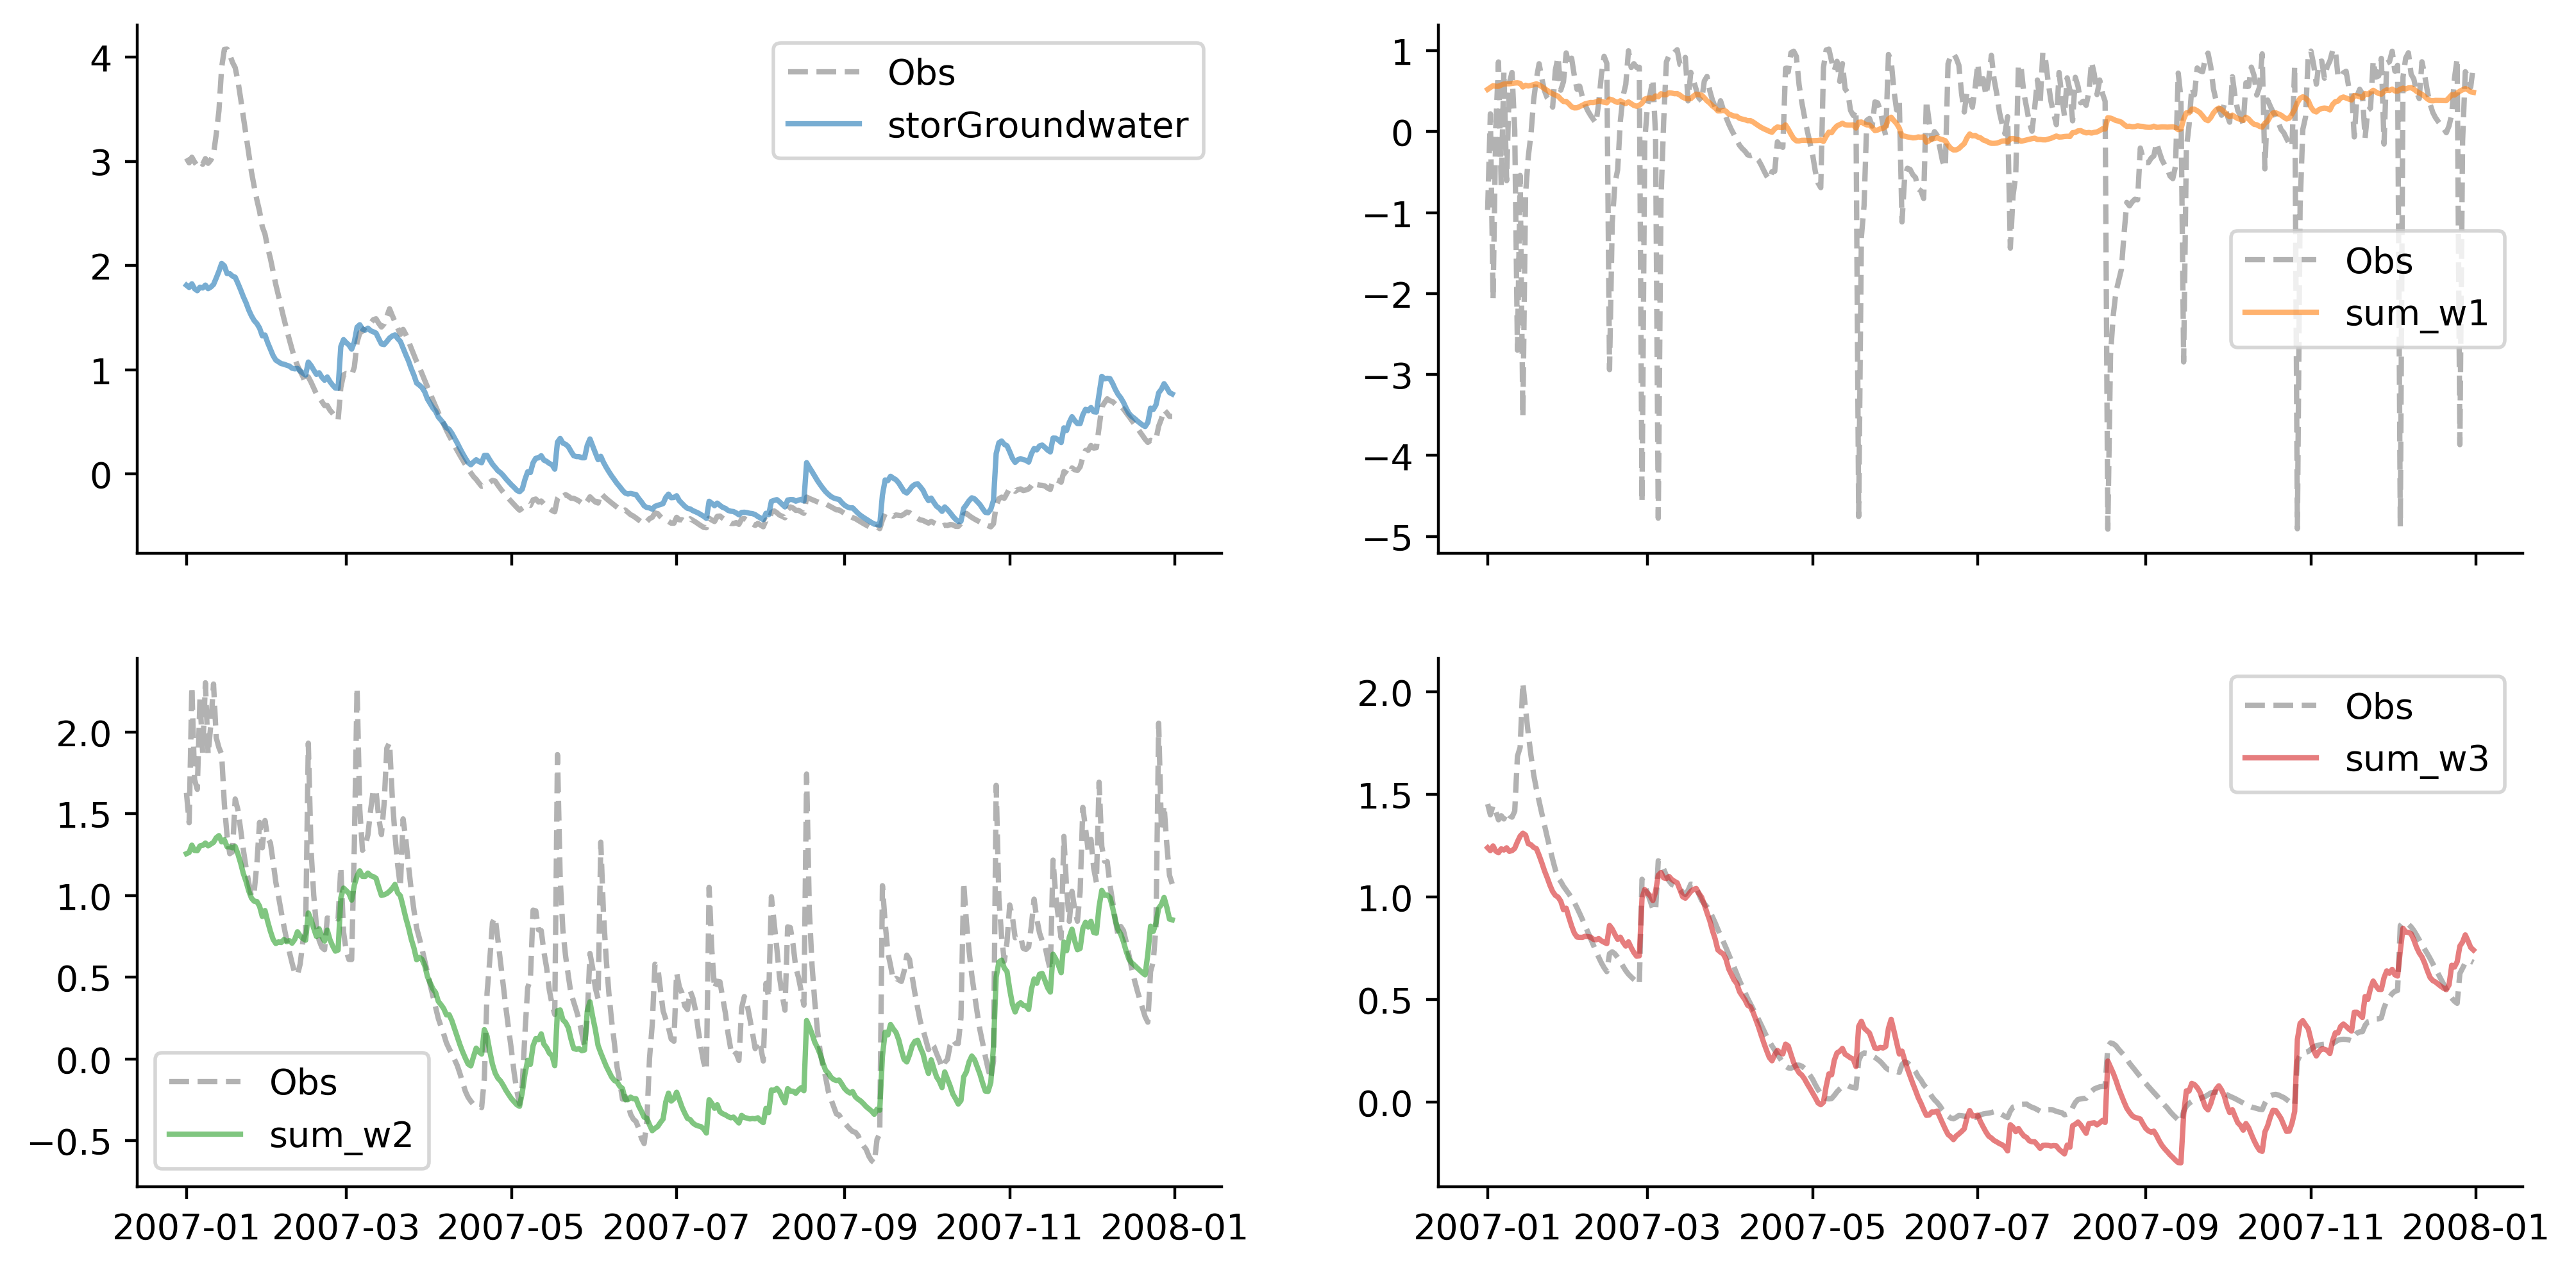

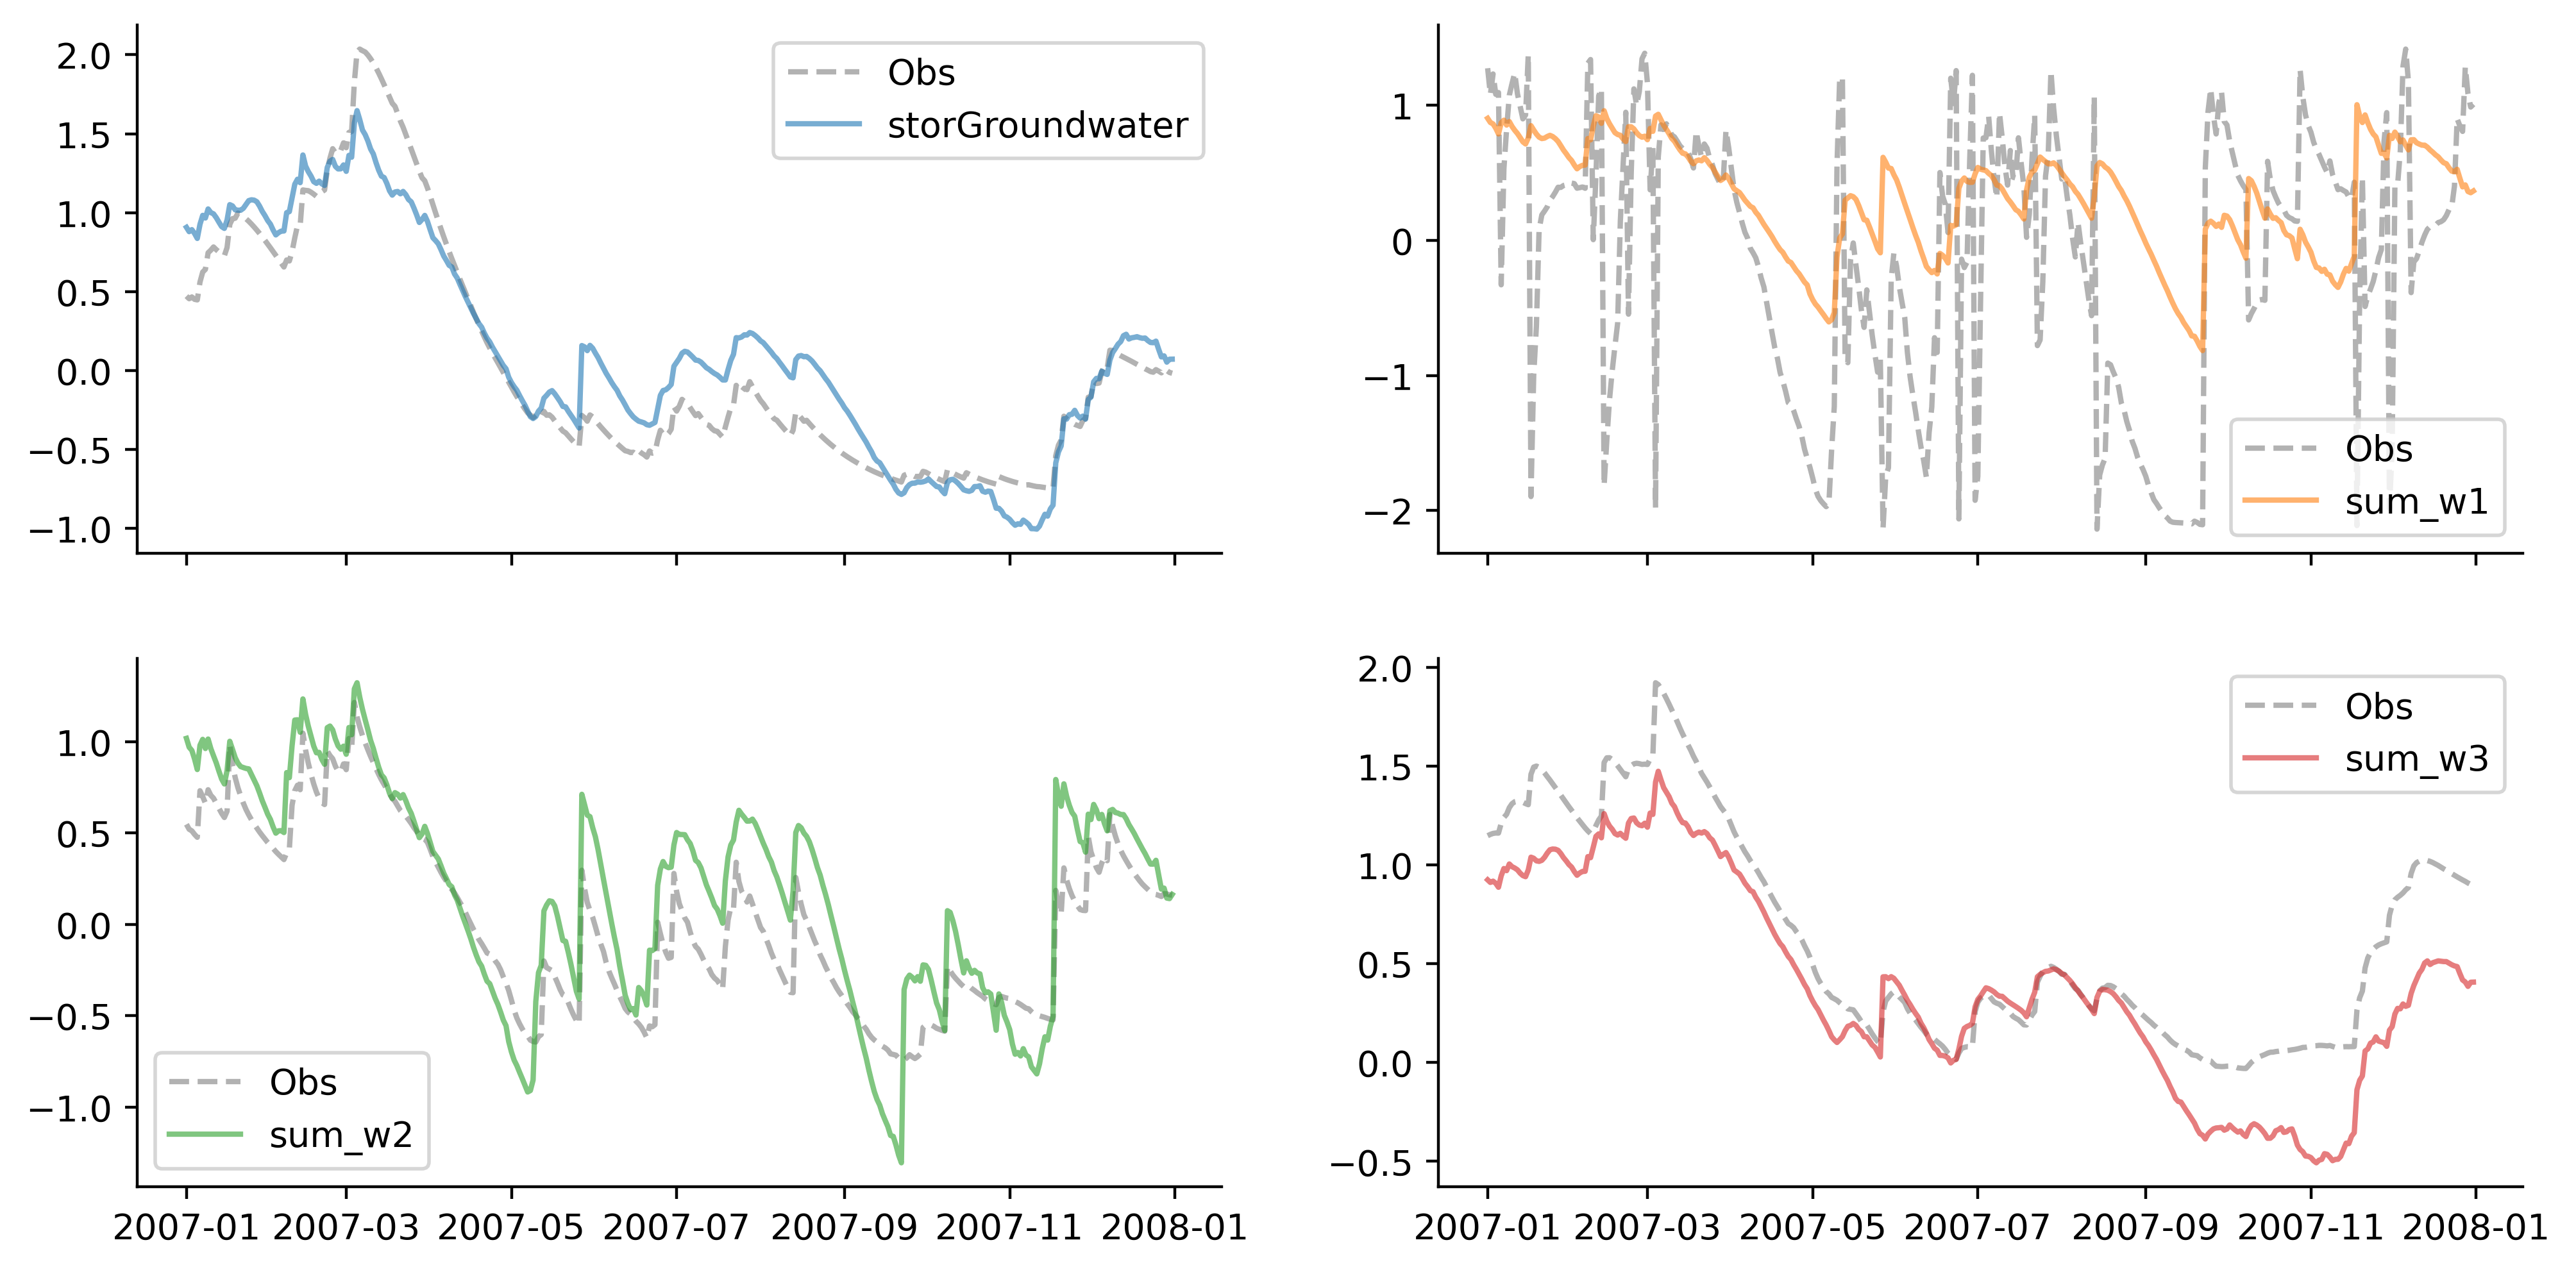

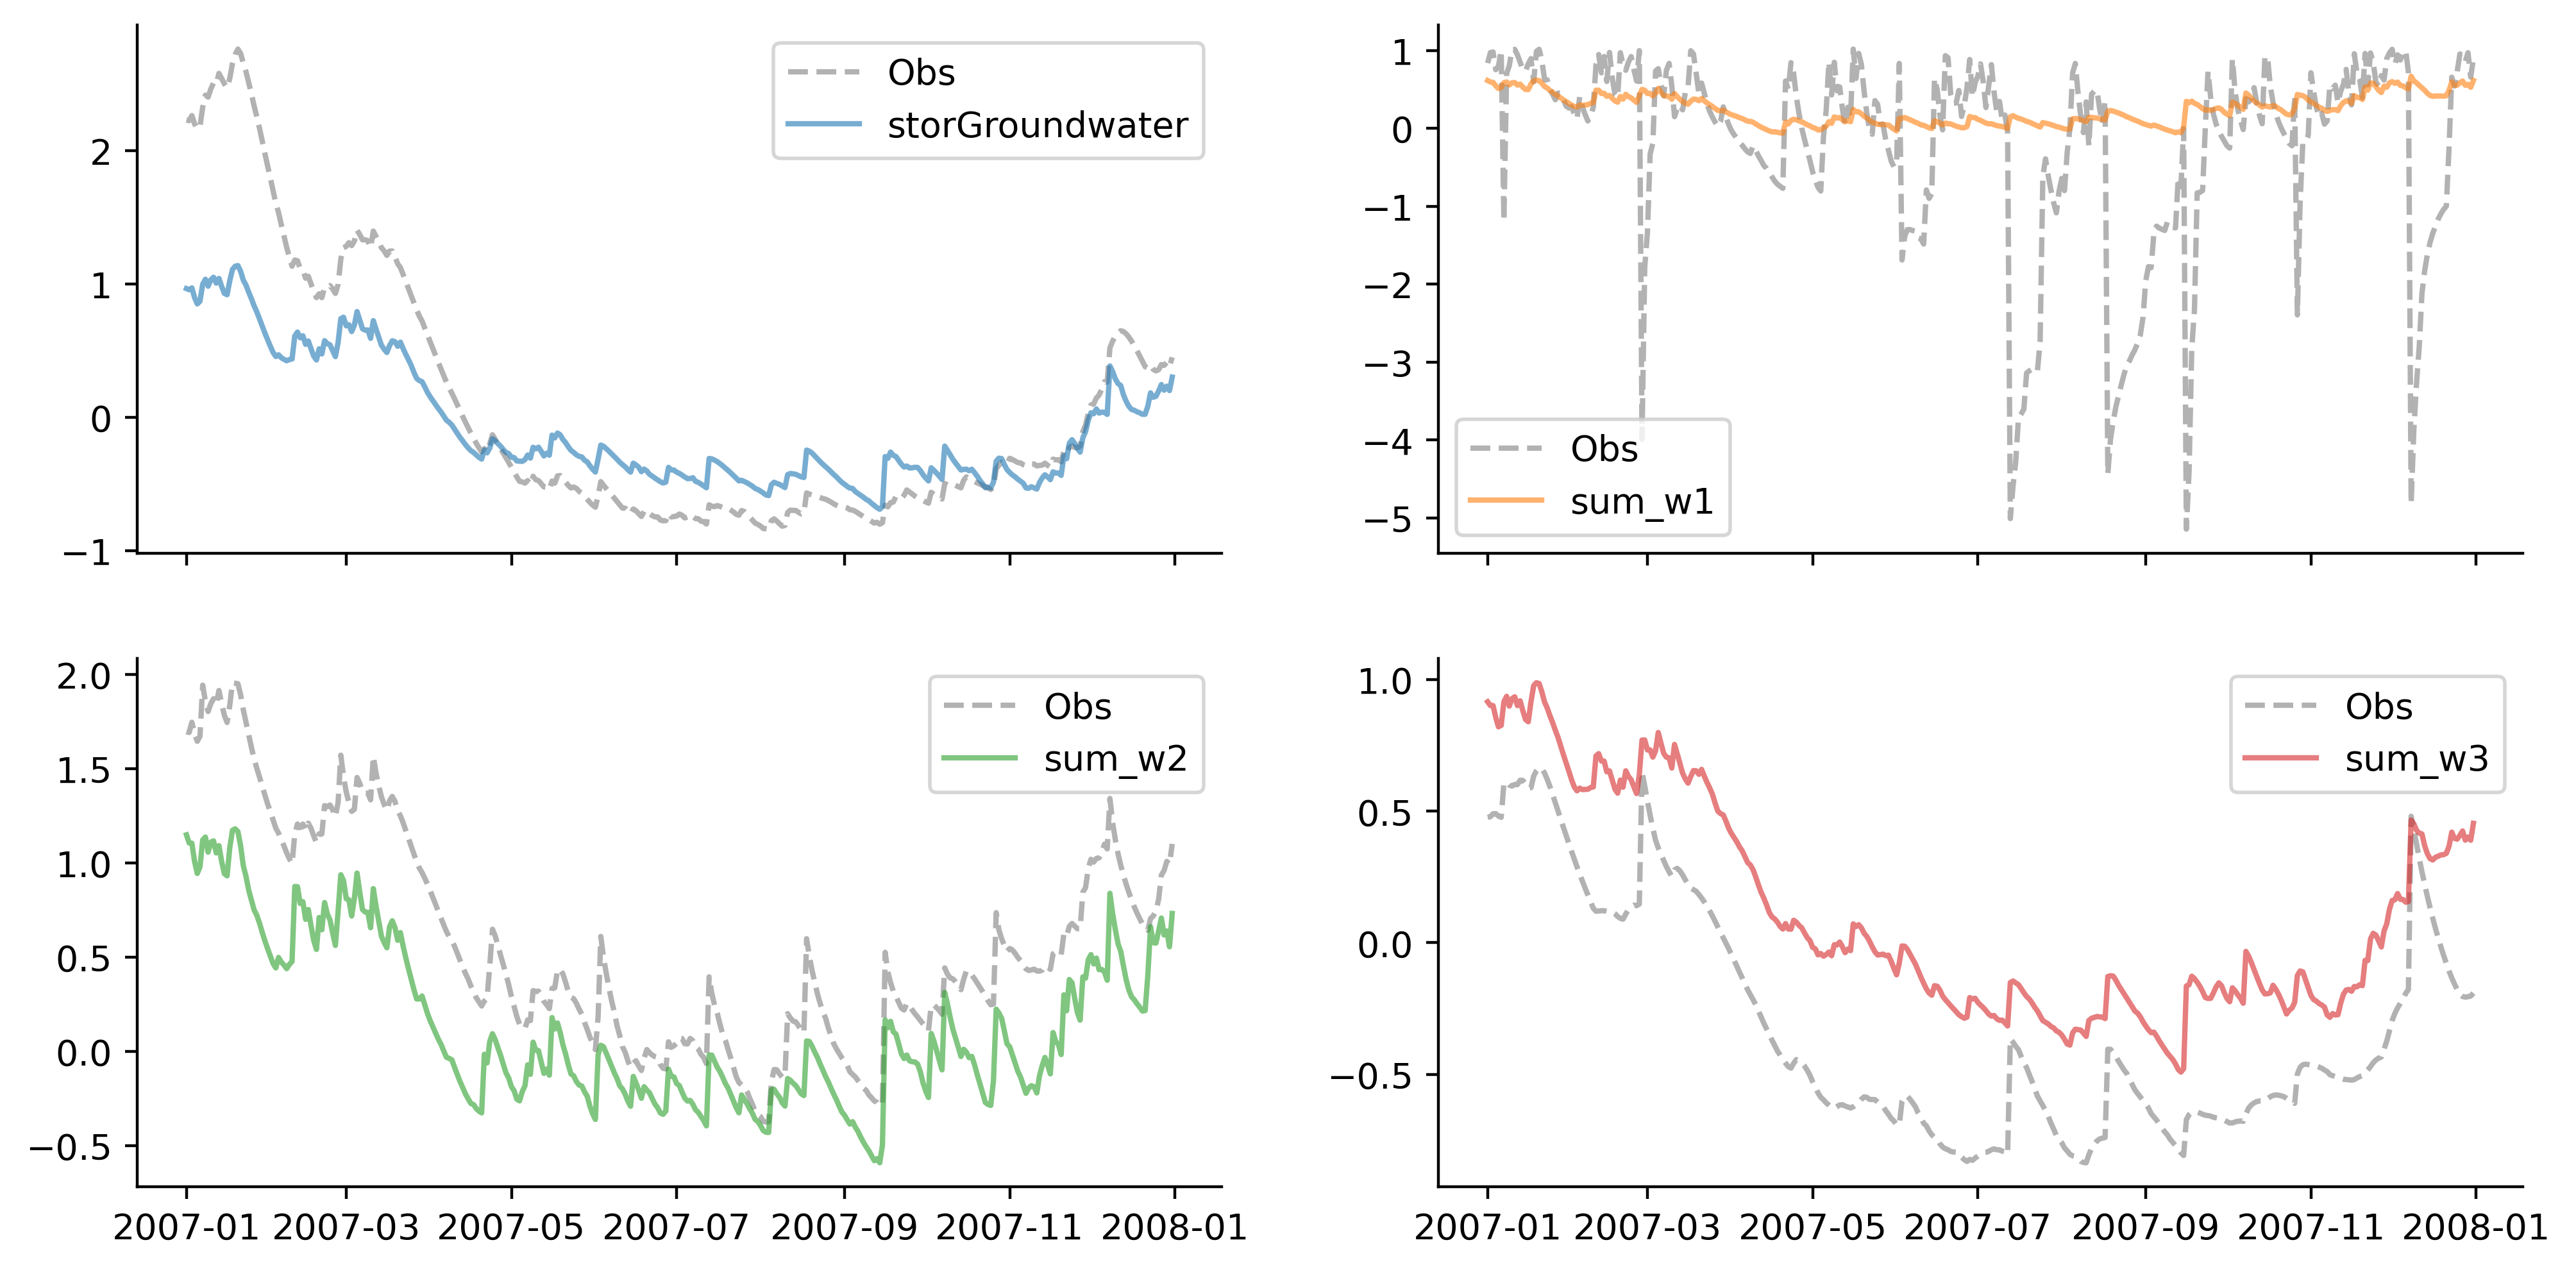

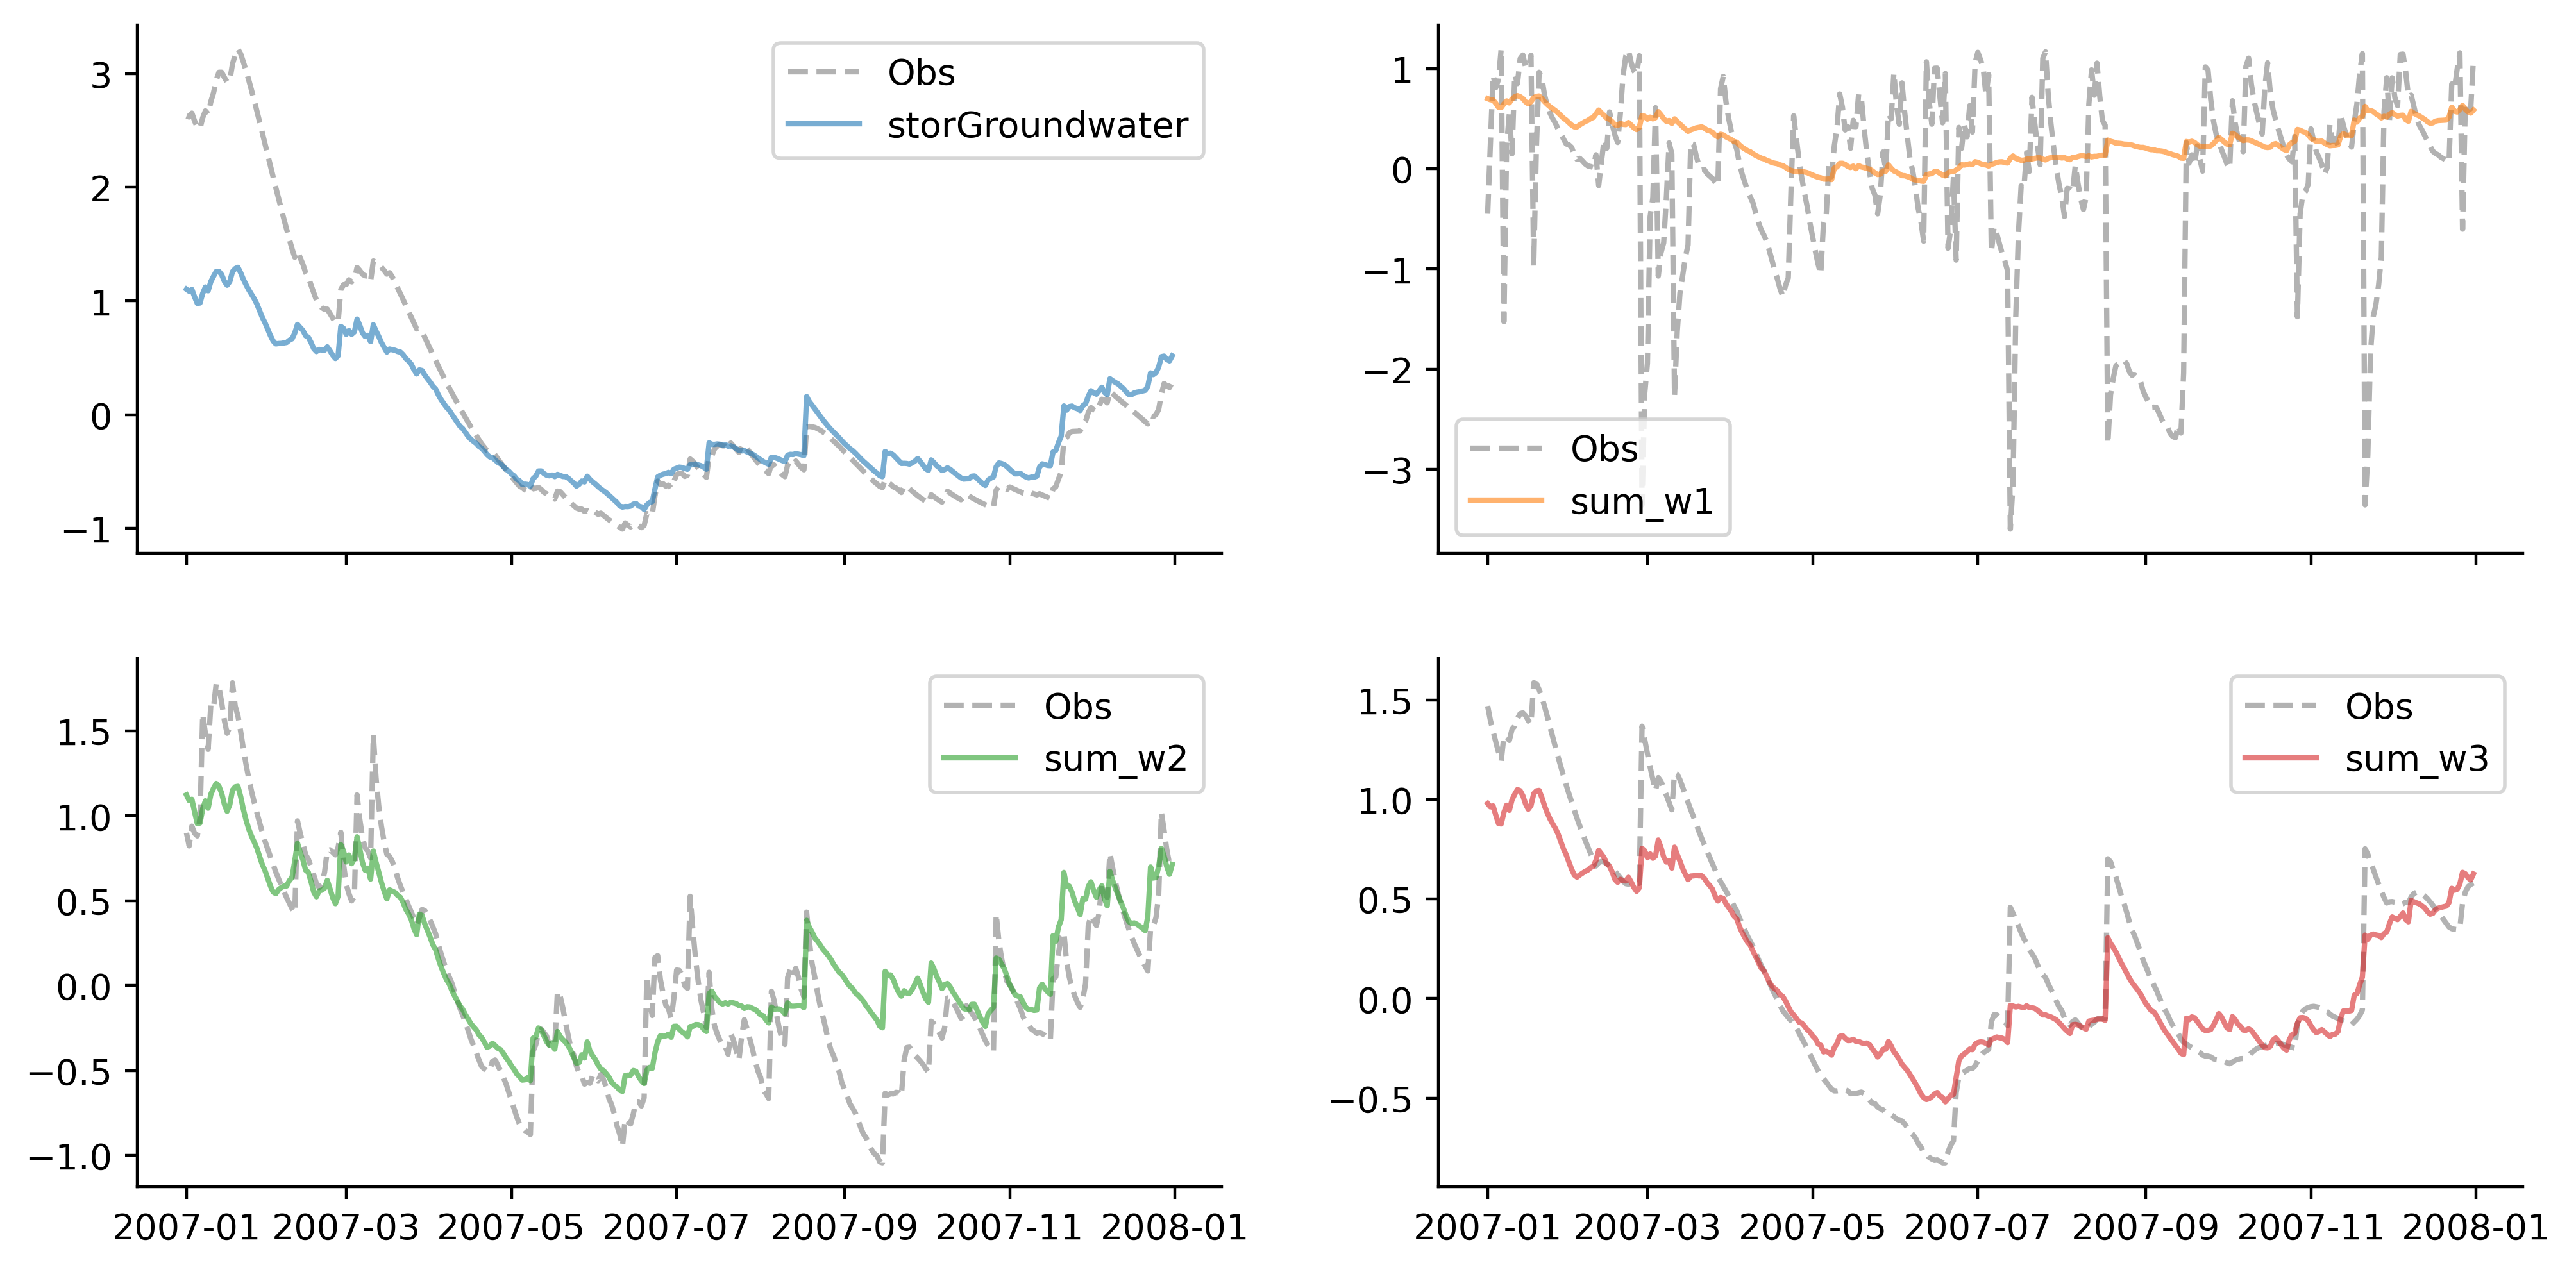

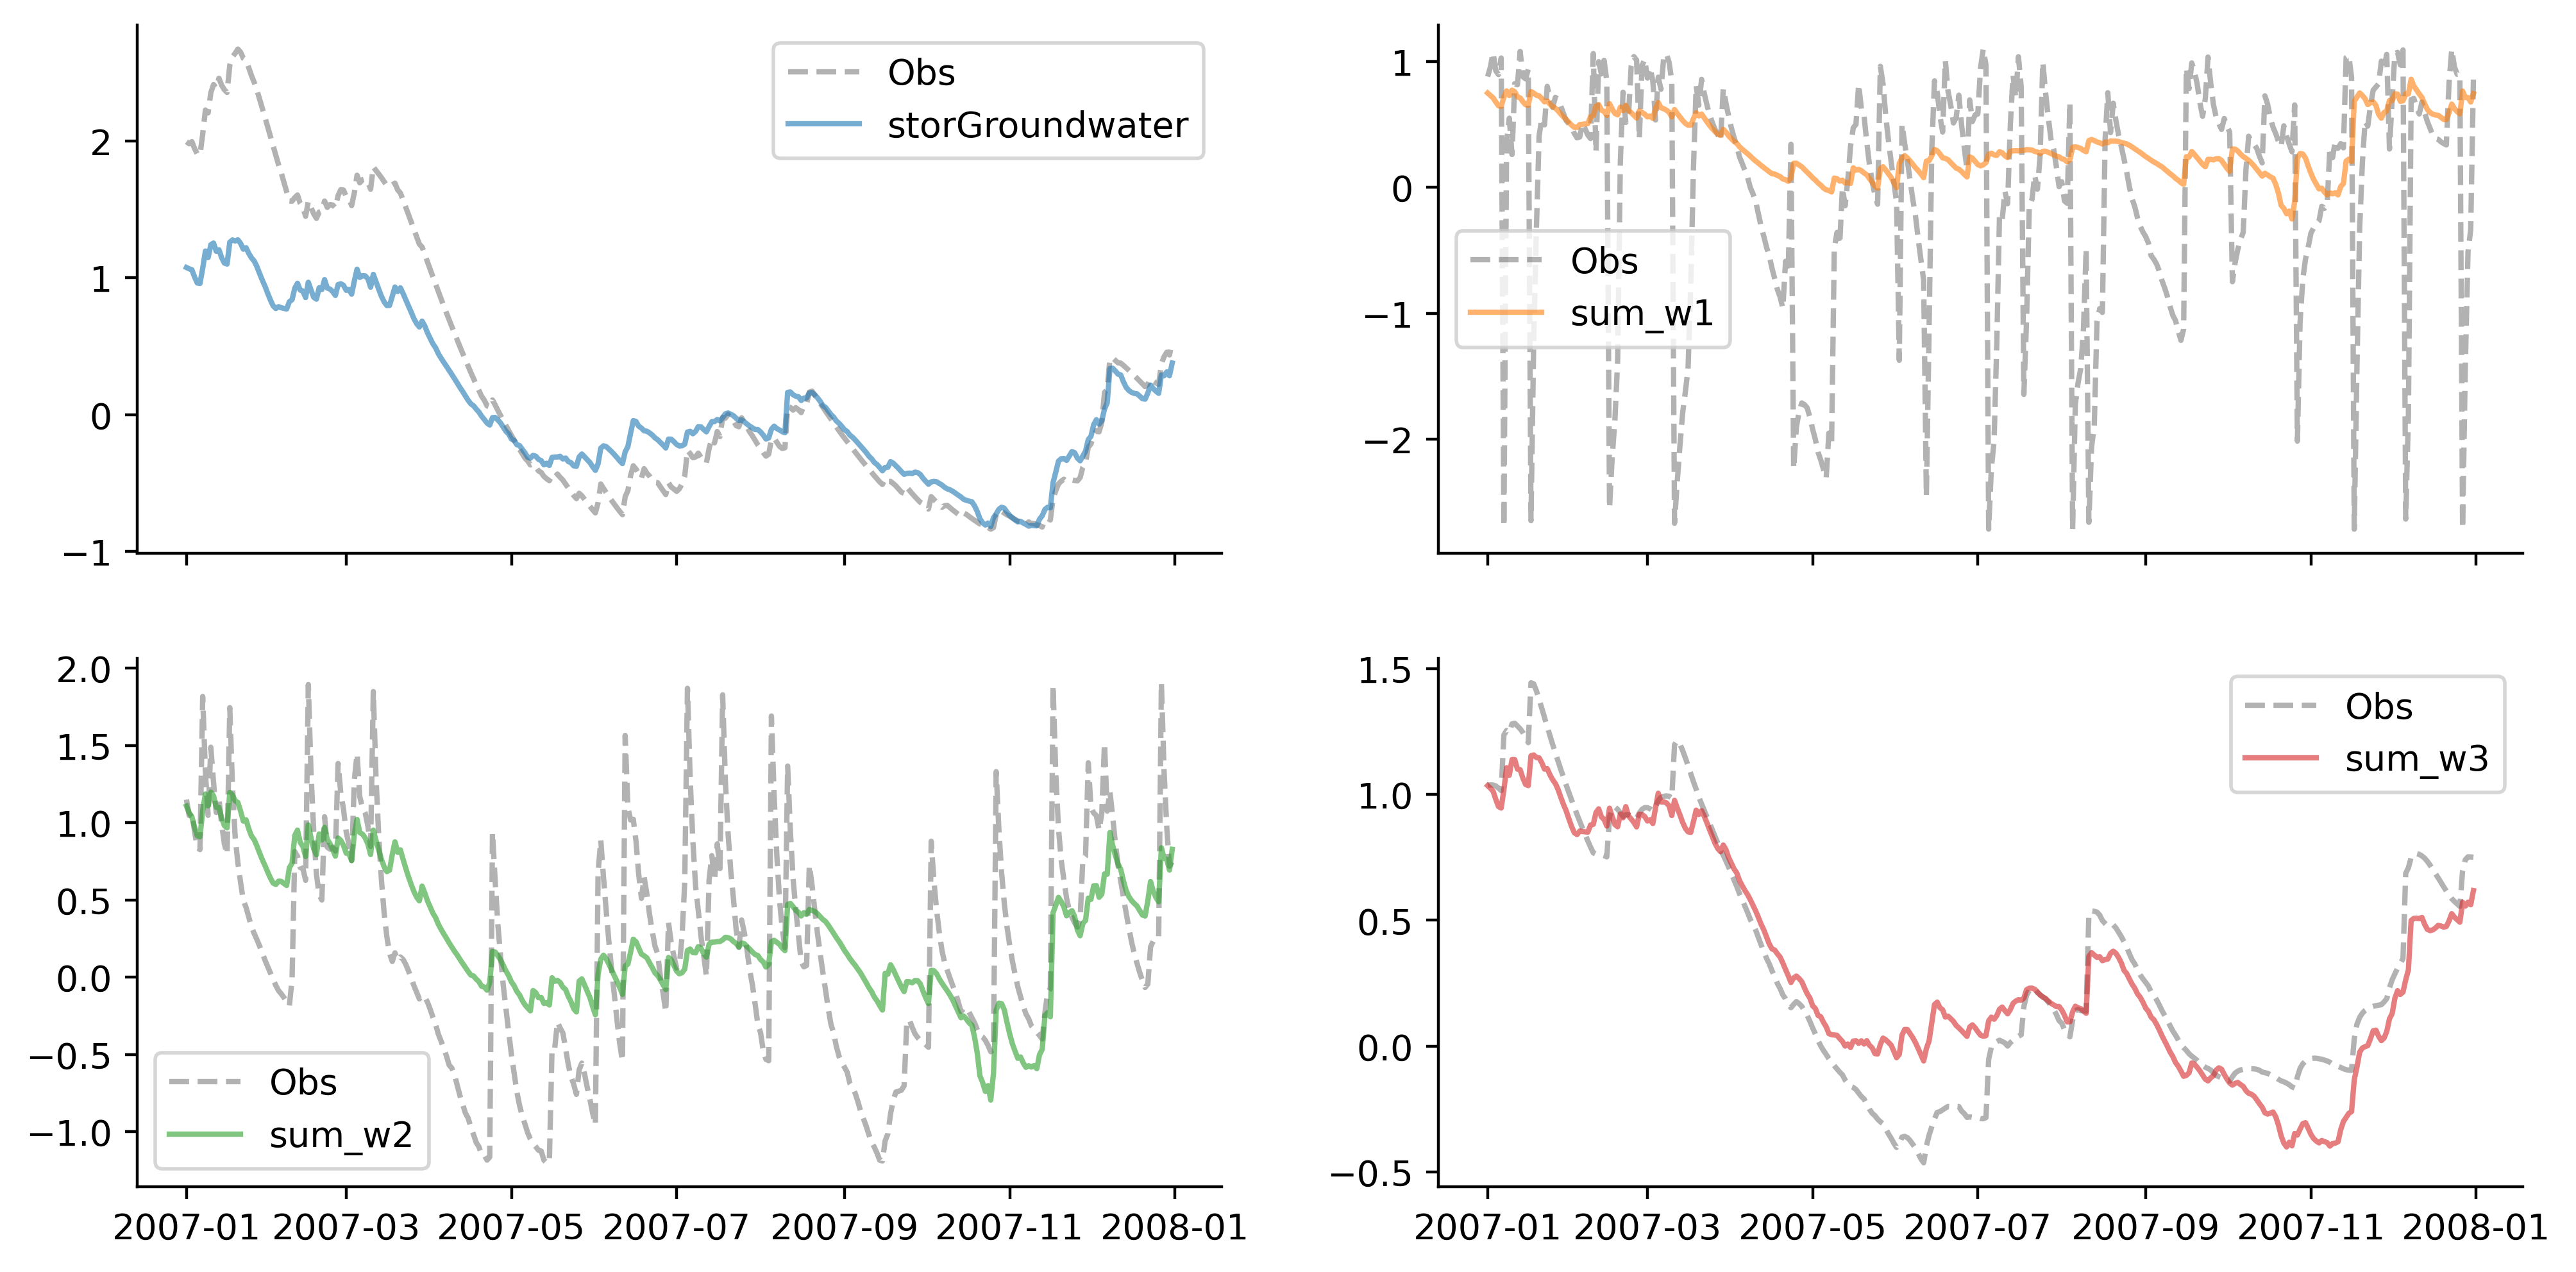

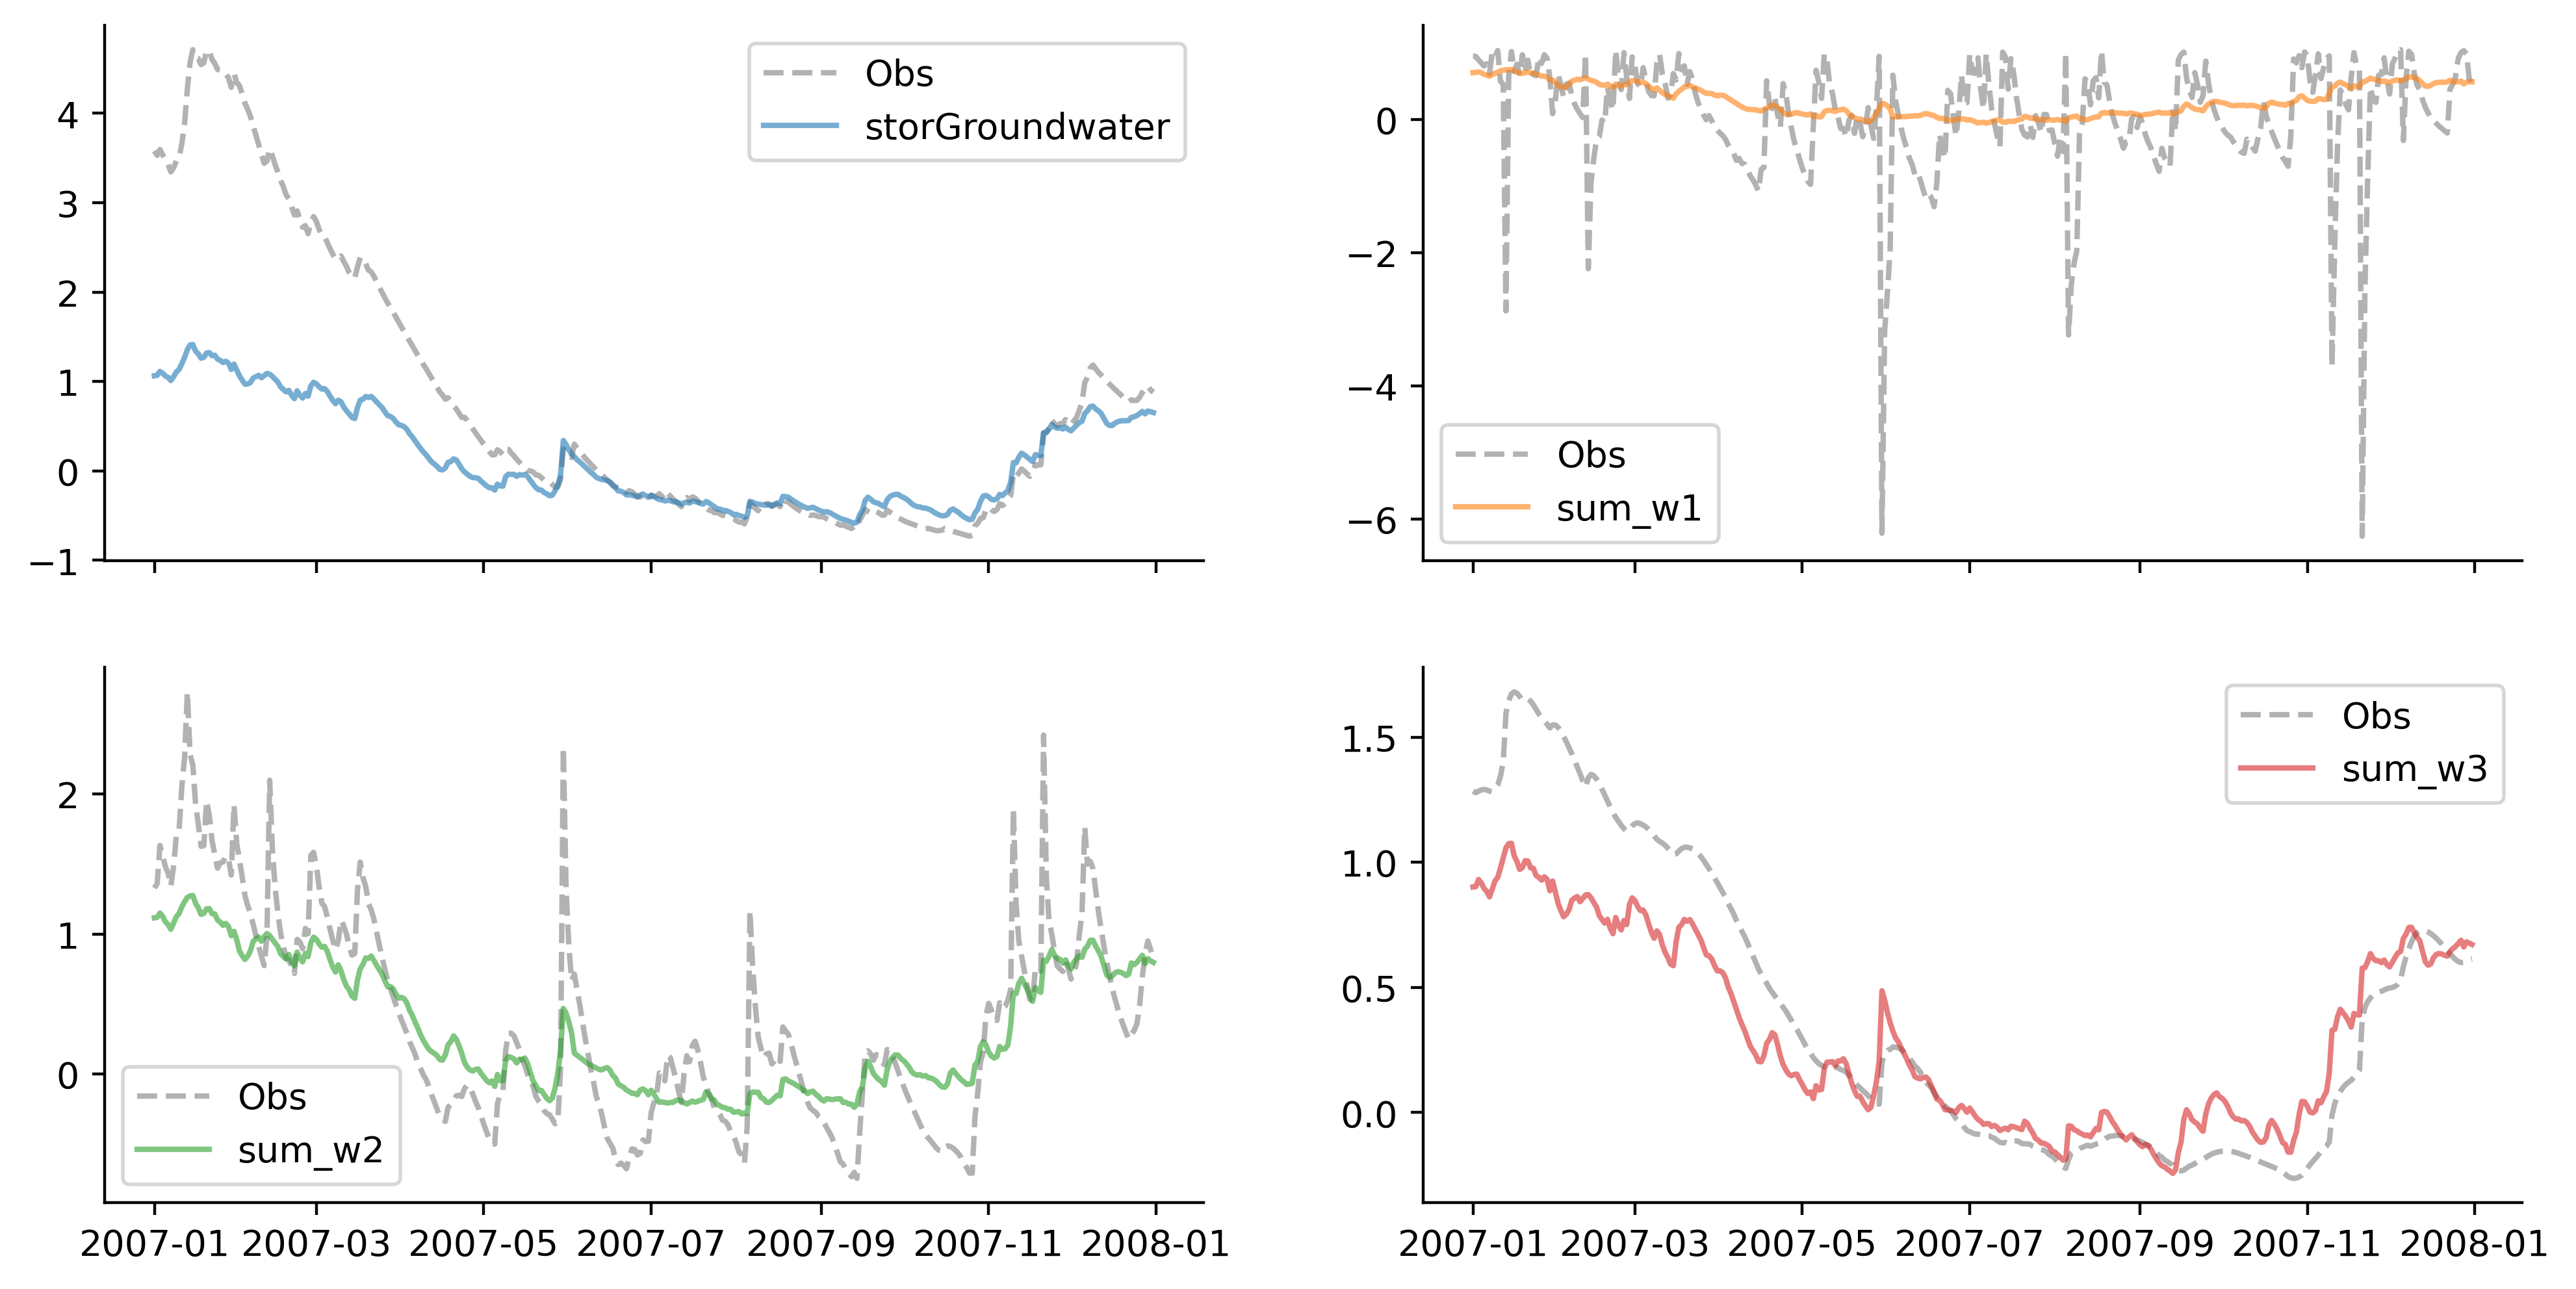

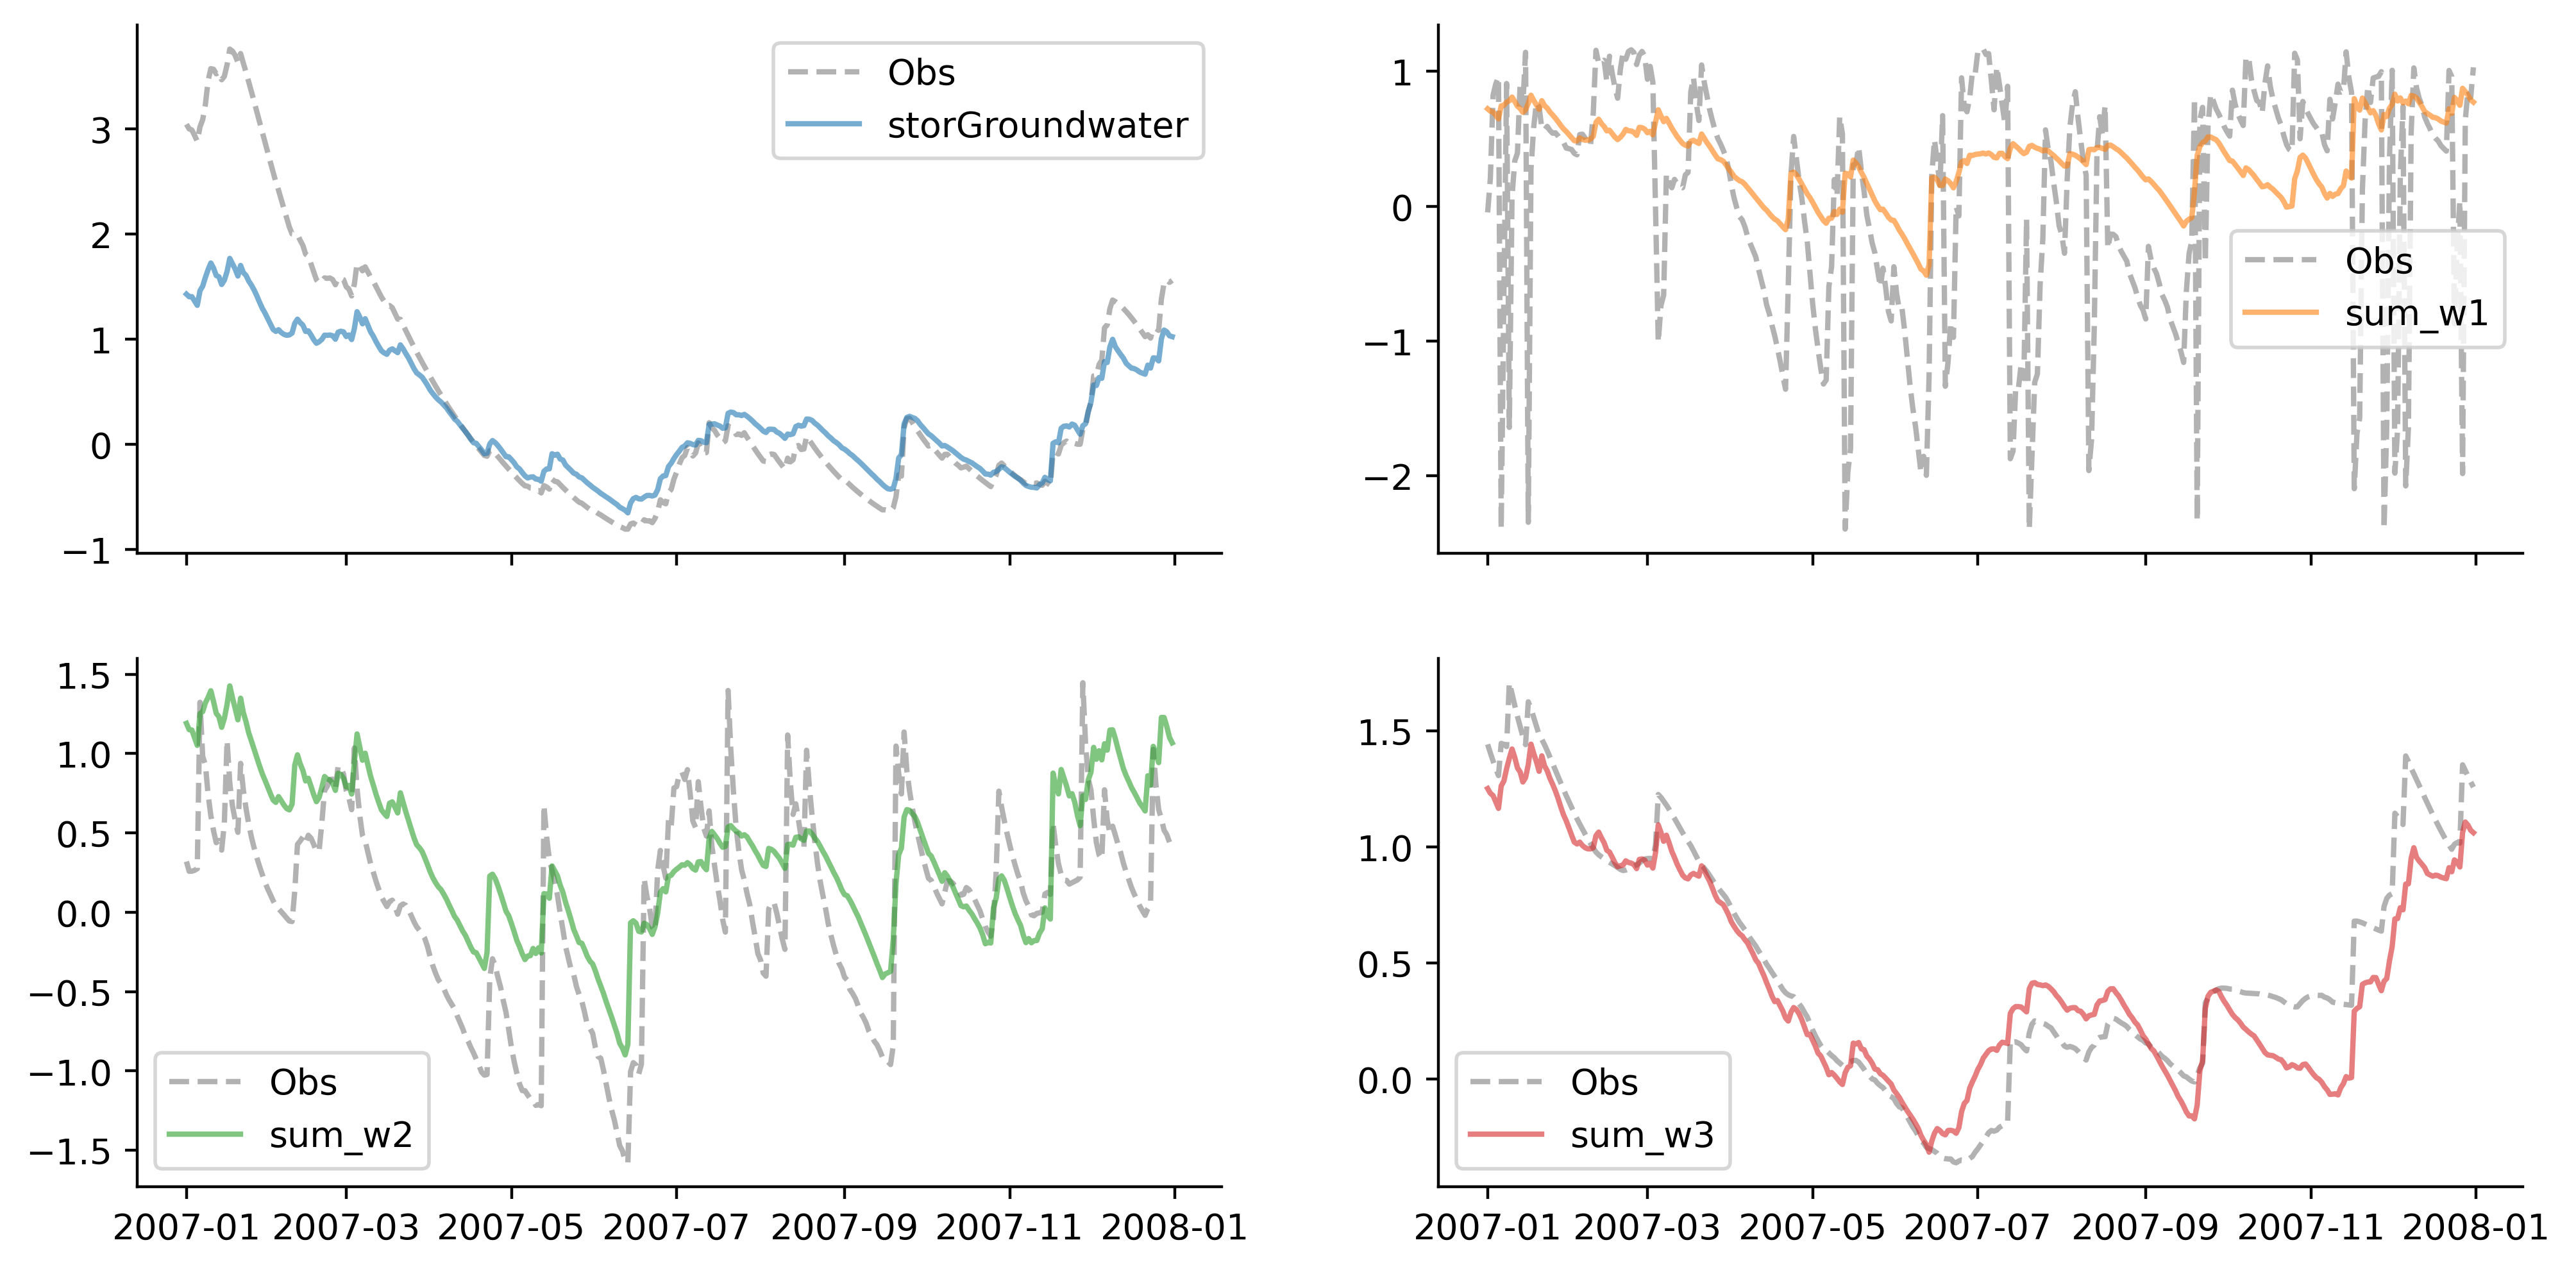

In [150]:
p = all_models_preds["storGroundwater"]["preds"]
time = "2007"

N = 10
pixels = np.random.choice(p.station_id.values, N, replace=False)

with plt.rc_context({'figure.dpi': 400}):
    for px in pixels:
        f, axs = plt.subplots(2, 2, figsize=(12, 2*3), sharex=True)
        for ix, target_var in enumerate(target_vars):
            ax = axs[np.unravel_index(ix, (3, 2))]
            preds = all_models_preds[target_var]["preds"]
            data = preds.sel(station_id=px, time=time)

        #     f, ax = plt.subplots(figsize=(12, 4))
            ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
            ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
            ax.legend()
            sns.despine()

### plot nse distributions

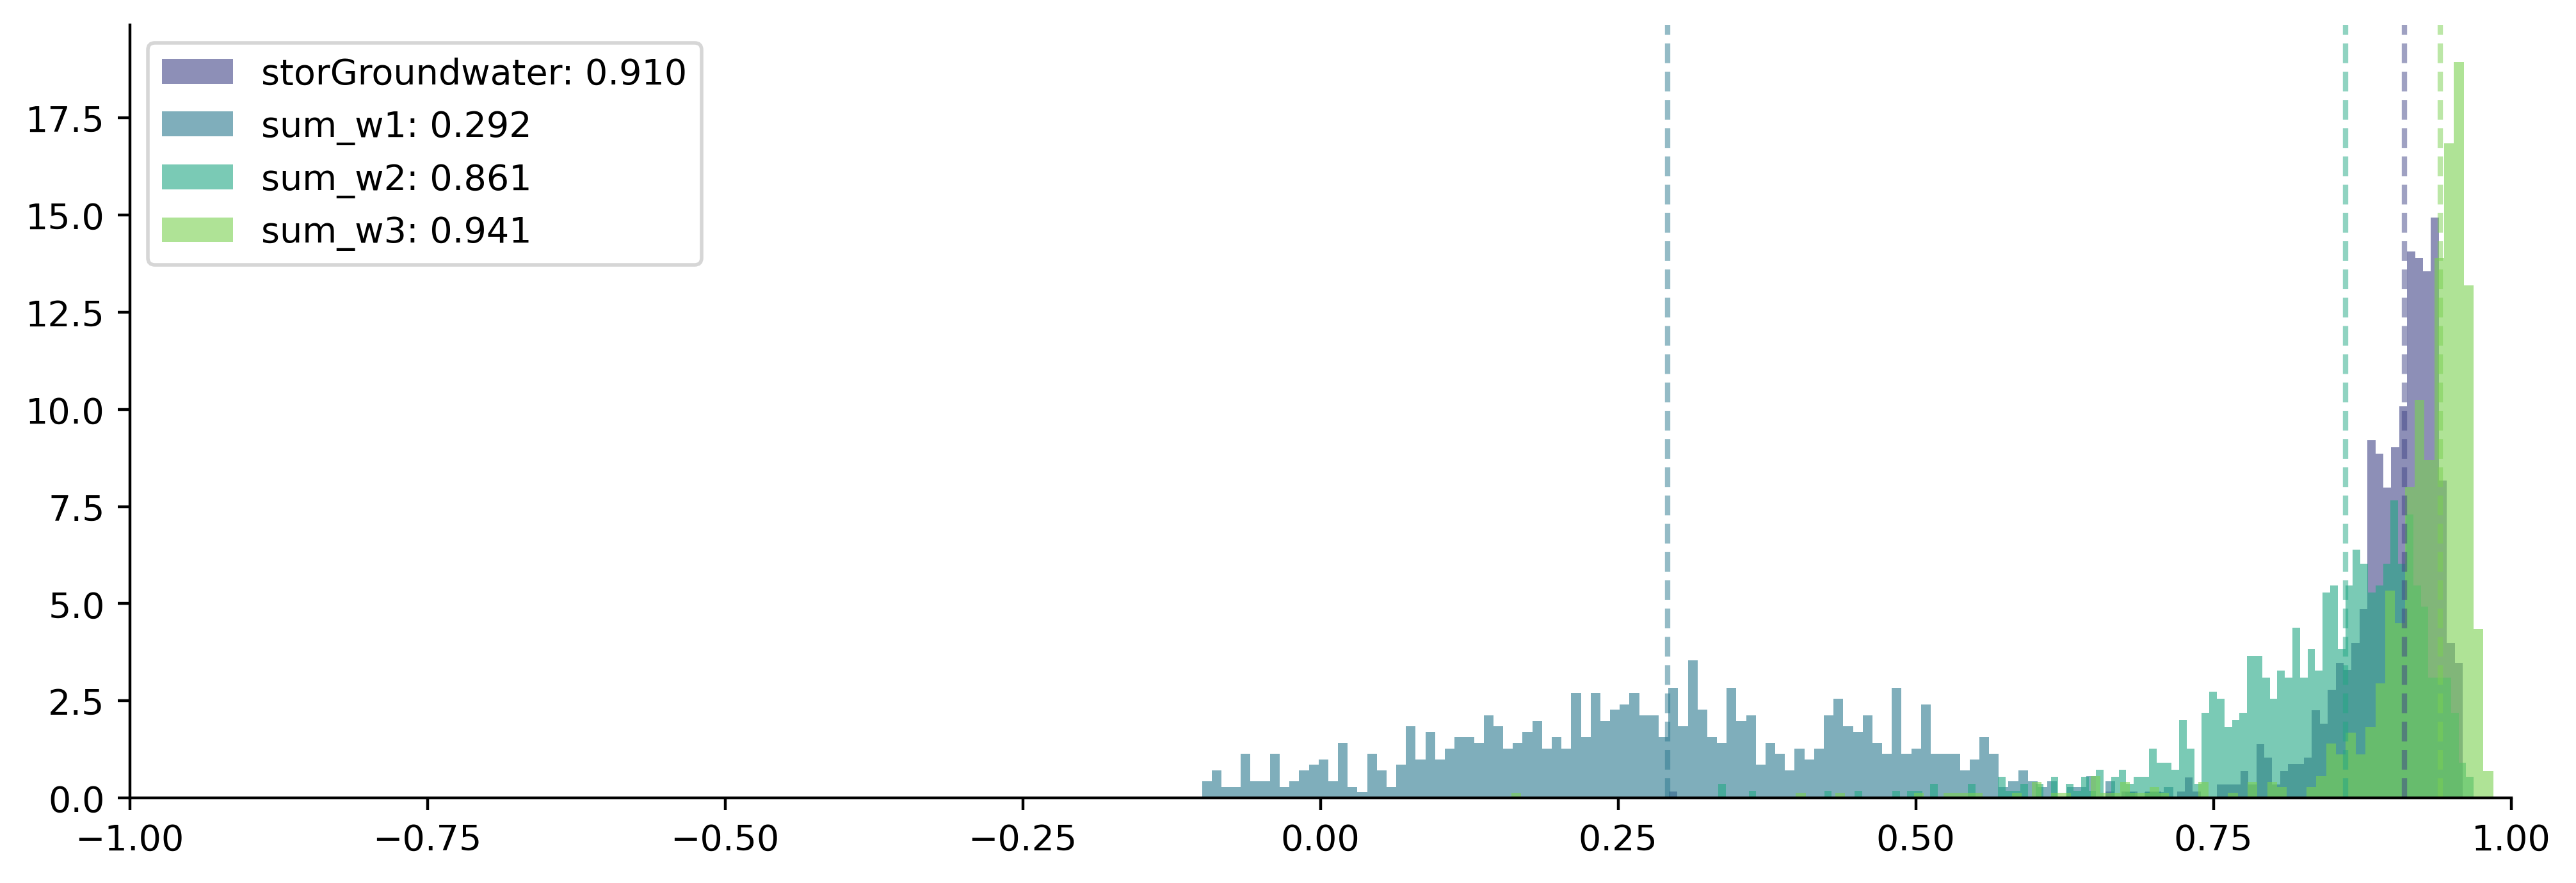

In [140]:
with plt.rc_context({'figure.dpi': 400}):

    f, ax = plt.subplots(figsize=(12, 4))

    colors = sns.color_palette("viridis", n_colors=len(target_vars))
    for ix, target_var in enumerate(target_vars):
        errors = all_models_preds[target_var]["errors"]
        nse = errors["Pearson-r"]

        ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
        ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)


    ax.set_xlim(-1, 1)
    ax.legend()
    sns.despine()

### plot the weights

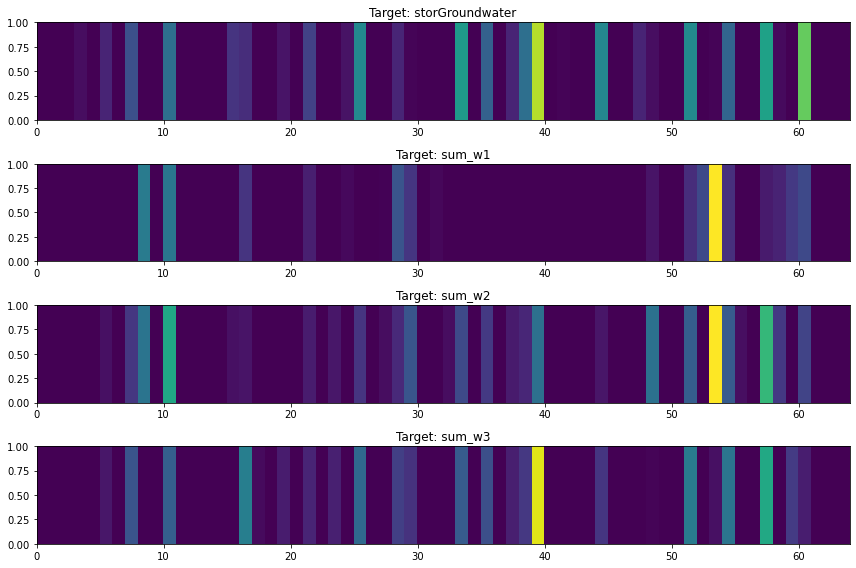

In [141]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix] if n_plots > 1 else axs
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

In [142]:
for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    w, b = get_model_weights(model)
    print(b)

[-0.03194351]
[0.25874353]
[0.11213694]
[0.1803774]


# What is going on in Level1?

In [143]:
# dynamic

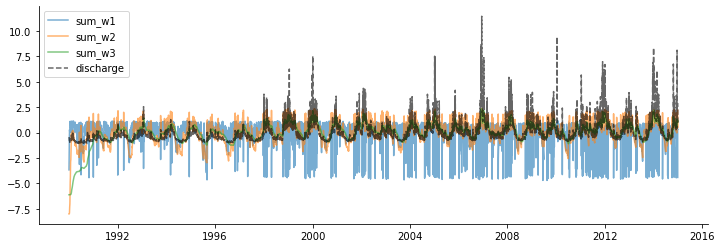

In [144]:
px = np.random.choice(dynamic.station_id)

f, ax = plt.subplots(figsize=(12, 4))
for var in [v for v in dynamic.data_vars if "sum_w" in v]:
    d = dynamic[var].sel(station_id=px)
    # normalize
    d = (d - d.mean()) / d.std()
    
    ax.plot(d.time, d, alpha=0.6, label=var)

var = "discharge"
d = dynamic[var].sel(station_id=px)
# normalize
d = (d - d.mean()) / d.std()
ax.plot(d.time, d, alpha=0.6, label=var, ls="--", color="k")

plt.legend()
sns.despine()

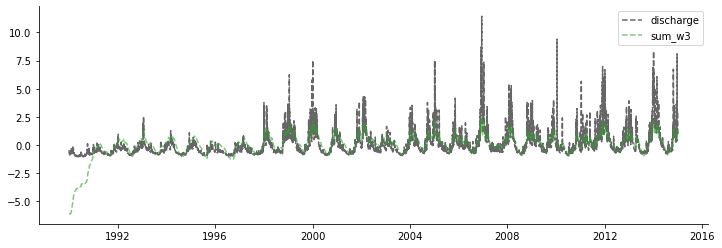

In [145]:
f, ax = plt.subplots(figsize=(12, 4))

colors = ["k", "C2"]
for ix, var in enumerate(["discharge", "sum_w3"]):
    d = dynamic[var].sel(station_id=px)
    # normalize
    d = (d - d.mean()) / d.std()
    ax.plot(d.time, d, alpha=0.6, label=var, ls="--", color=colors[ix])
plt.legend()
sns.despine()

In [146]:
# sum_w1 = xr.open_dataset(data_dir / "CWATM/sum_w1_daily.nc")
# d = sum_w1.isel(x=100, y=100)

# f, ax = plt.subplots(figsize=(12, 4))
# ax.plot(d.time, d, alpha=0.6, label=var, ls="--", color="C0")


# Look at the underlying dataset

In [147]:
original = xr.open_dataset(data_dir / "CWATM/sum_w1_daily.nc", chunks={"x": 10, "y": 10})
original = original.sel(time=slice("2000", "2010"))
original

<xarray.Dataset>
Dimensions:                       (time: 4018, x: 674, y: 1067)
Coordinates:
  * x                             (x) float64 3.142e+06 3.144e+06 ... 3.816e+06
  * y                             (y) float64 4.126e+06 4.126e+06 ... 3.060e+06
  * time                          (time) datetime64[ns] 2000-01-01 ... 2010-1...
Data variables:
    lambert_azimuthal_equal_area  int32 ...
    sum_w1                        (time, y, x) float32 dask.array<chunksize=(4018, 10, 10), meta=np.ndarray>
Attributes:
    settingsfile:     /scistor/ivm/jbn271/DATA/CWatM/1keurope/settings/settin...
    run_created:      Thu Jul  1 14:33:27 2021
    Source_Software:  CWATM Python: /scistor/ivm/jbn271/DATA/CWatM/1keurope/c...
    Platform:         Linux
    Version:          1.4: List_all_variables.py 2021/07/01 14:32
    institution:      IIASA
    title:            European Water Model - Europe 1km
    source:           CWATM output maps
    Conventions:      CF-1.6
    description:      
    author:           IIASA WAT

In [148]:
original.isel(time=100)["sum_w1"].plot()

KeyboardInterrupt: 

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    example_point = original.sel(x=3.6*1e6, y=3.3*1e6, method="nearest")["sum_w1"].compute()

In [ ]:
pt_values = example_point.values

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(example_point.time, example_point.values)
ax.set_title(f"X={3.6*1e6} y={3.3*1e6}")
sns.despine()

# Train Non Linear Model (comparison)

In [ ]:
assert False, "The NL models take much longer!"

In [ ]:
from scripts.cell_state.sklearn_models import fit_and_predict

if "nonlinear_dict" not in globals().keys():
    if nonlinear_dict == {}:
        # initalise the model 
        nonlinear_dict = defaultdict(dict)
        target_vars = [v for v in target_data.data_vars]

        for target_var in [v for v in target_data.data_vars]:
            print(f"** {target_var} **")
            model, preds, errors = fit_and_predict(
                all_train_test[target_var]["train"], 
                all_train_test[target_var]["test"], 
                random_seed=100, 
                linear=False, 
                hidden_sizes=[10,10]
            )
            nonlinear_dict[target_var]["model"] = model
            nonlinear_dict[target_var]["preds"] = preds
            nonlinear_dict[target_var]["errors"] = errors

In [ ]:
p = nonlinear_dict["storGroundwater"]["preds"]
time = "2007"

N = 2
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    f, axs = plt.subplots(2, 2, figsize=(12, 2*3), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (2, 2))]
        preds = nonlinear_dict[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3, label="Obs")
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = nonlinear_dict[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()